# 📊 Entrega del Trabajo Final
## Jefry Llerena y David Lizcano

### Asignatura: Series de Tiempo
#### Maestría en Analítica de Datos

---

## Análisis y Predicción de las Series Temporales de las Ventas de Pizza

# Análisis y Modelización de Ventas Diarias de Pizzas

## Introducción
Este proyecto se centra en el análisis y modelización de una serie de tiempo que representa las ventas diarias de pizzas en un restaurante durante un año. El objetivo principal es aplicar diferentes técnicas de series de tiempo para predecir las ventas futuras y mejorar la precisión de las estimaciones, lo que permitirá optimizar la gestión operativa del restaurante.

## Estructura del Proyecto
El trabajo está estructurado en cuatro componentes clave:

### 1. Análisis Exploratorio de Datos (10%)
Se realiza una exploración inicial de los datos para identificar patrones de comportamiento, tendencias y estacionalidades en las ventas. Esta fase orienta la selección de los modelos a utilizar.

### 2. Modelos Benchmark (20%)
Se implementan modelos clásicos como:
- **Suavizado Exponencial (ES)**
- **Holt-Winters**
- **ARIMA**
- **Redes Neuronales Artificiales (ANNs)**

Estos modelos establecen una línea base de comparación.

### 3. Exposición (10%)
Se presenta el proceso seguido y los resultados obtenidos en clase del sabado 27

### 4. Modelo Original (60%)
El núcleo del proyecto radica en desarrollar un modelo propio que logre superar la precisión de los modelos benchmark, optimizando así las predicciones de ventas.


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt

# Analisis exploratorio de los datos

Número de observaciones: 358
Usando periodo: 12


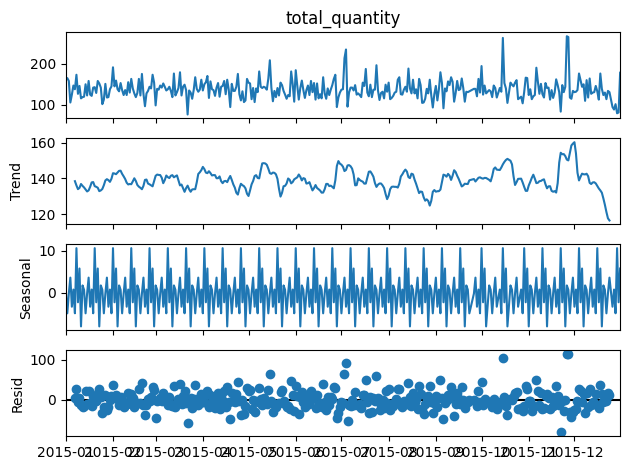

In [3]:
# Leer el archivo Excel
df = pd.read_excel(r"C:\Users\Davidlizcanom2486\Documents\Timeseries\jbook_ts202330\docs\PizzaSales.xlsx")

# Convertir la columna de fecha
df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=False, errors='coerce')

# Agrupar por fecha y sumar la cantidad diaria (Quantity)
df_grouped_quantity = df.groupby('order_date').agg(total_quantity=('quantity', 'sum')).reset_index()

# Establecer la fecha como índice
df_grouped_quantity.set_index('order_date', inplace=True)

# Resamplear la serie de tiempo a una frecuencia diaria
df_grouped_quantity_daily = df_grouped_quantity.resample('D').sum()

# Reemplazar ceros con NaN
df_grouped_quantity_daily['total_quantity'] = df_grouped_quantity_daily['total_quantity'].replace({0: None})

# Eliminar filas con valores faltantes
df_grouped_quantity_daily = df_grouped_quantity_daily.dropna()


# Verificar cuántas observaciones hay en la serie diaria
print(f"Número de observaciones: {df_grouped_quantity_daily.shape[0]}")

# Ajustar el periodo según el número de observaciones
periodo = 12 if df_grouped_quantity_daily.shape[0] >= 24 else df_grouped_quantity_daily.shape[0] // 2
print(f"Usando periodo: {periodo}")

# Usar descomposición aditiva
dec = sm.tsa.seasonal_decompose(df_grouped_quantity_daily['total_quantity'], model='additive', period=periodo).plot()
plt.show()



Serie original (total_quantity): Aquí se reflejan las fluctuaciones diarias de las ventas de pizzas en el restaurante durante dos años. Se notan variaciones importantes y picos, que probablemente corresponden a días de alta demanda como fines de semana o eventos especiales.

Tendencia (Trend): La tendencia muestra que las ventas han tenido periodos de crecimiento y decrecimiento. Aunque hay un incremento durante ciertos meses, se ve una caída hacia el final del periodo, lo que podría estar relacionado con una disminución estacional en la demanda o algún factor externo.

Componente estacional (Seasonal): El componente estacional sugiere que las ventas tienen un comportamiento cíclico muy claro. Esto podría estar vinculado a los patrones de consumo regulares, como los fines de semana o feriados, donde se repiten picos de ventas en ciertos días de la semana o en épocas del año.

Residuos (Resid): Los residuos representan las variaciones no explicadas por la tendencia y la estacionalidad. Aunque la mayoría de los puntos están cercanos a cero, hay algunos residuos más grandes que podrían indicar eventos excepcionales o factores fuera de lo habitual que afectaron las ventas, como promociones o cambios inesperados en la demanda.

En conjunto, esta descomposición sugiere que las ventas de pizzas siguen un patrón estacional fuerte, con una tendencia que ha experimentado cambios a lo largo del tiempo y unos residuos que parecen estar mayormente distribuidos de manera aleatoria.

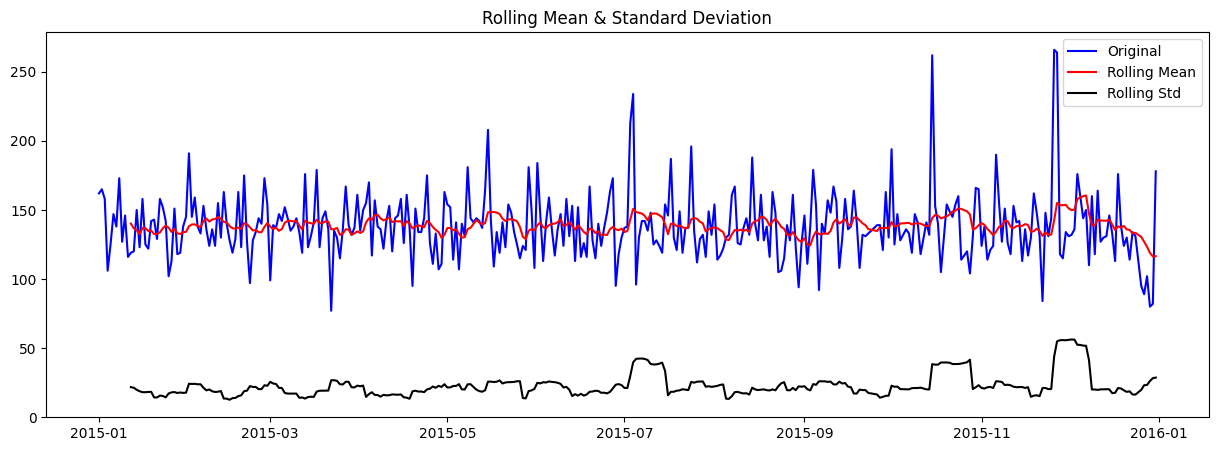

Results of Dickey-Fuller Test:
Test Statistic                  -5.220180
p-value                          0.000008
#Lags Used                      15.000000
Number of Observations Used    342.000000
Critical Value (1%)             -3.449616
Critical Value (5%)             -2.870028
Critical Value (10%)            -2.571292
dtype: float64


In [4]:
# Función para realizar la prueba de Dickey-Fuller y graficar la media móvil y desviación estándar
def test_stationarity(timeseries):
    # Calcular la media móvil y la desviación estándar móvil
    MA = timeseries.rolling(window=12).mean()  # Ajusta la ventana si es necesario
    MSTD = timeseries.rolling(window=12).std()  # Ajusta la ventana si es necesario

    # Graficar los valores originales, la media móvil y la desviación estándar
    plt.figure(figsize=(15, 5))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Realizar la prueba de Dickey-Fuller
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Aplicar la prueba de Dickey-Fuller y graficar los estadísticos móviles
test_stationarity(df_grouped_quantity_daily['total_quantity'])


Con esto, parece que hay suficiente evidencia para rechazar la hipótesis nula de que la serie temporal tiene una raíz unitaria, lo que sugiere que la serie es estacionaria. El estadístico de prueba es mucho menor que los valores críticos, y el p-valor es muy bajo, así que estoy bastante seguro de que puedo considerar la serie como estacionaria. Esto es un buen indicio para los siguientes pasos en el análisis.

## Grafico de normalidad y grafico Boxplot para el EDA

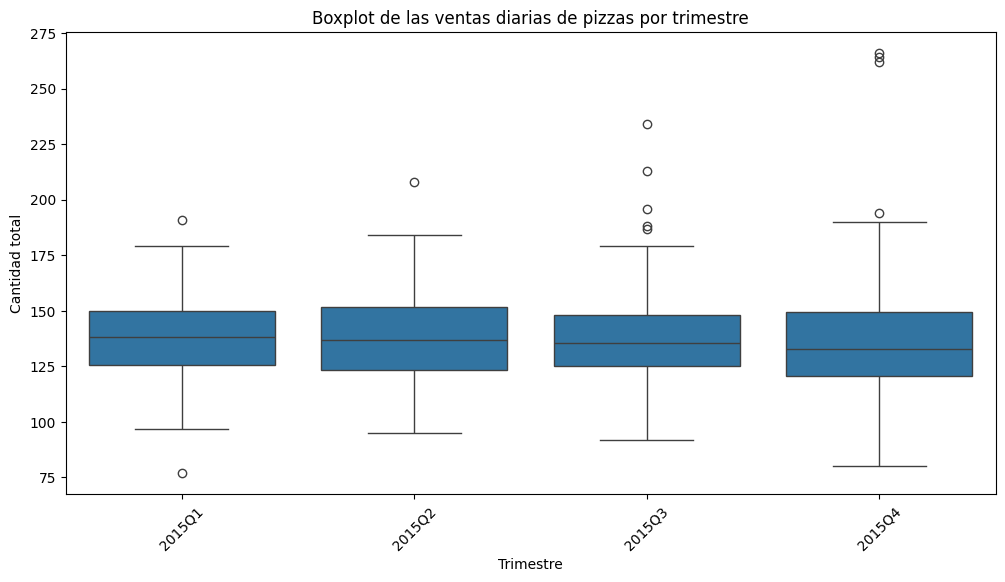

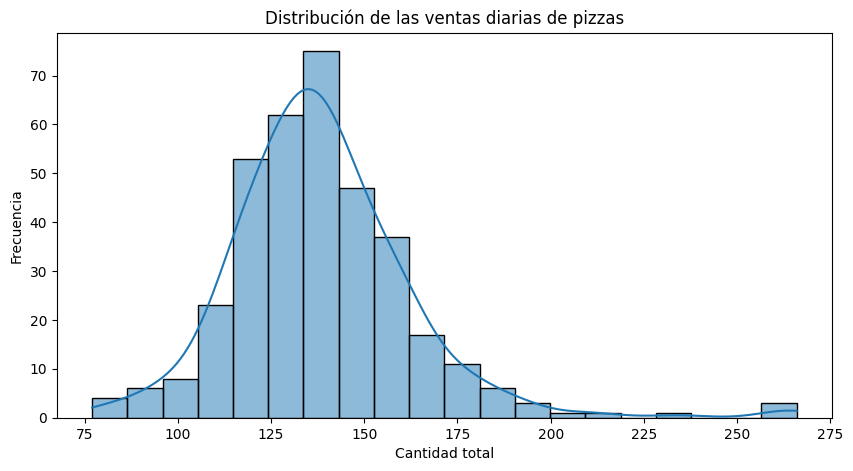

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Leer el archivo Excel
df = pd.read_excel(r"C:\Users\Davidlizcanom2486\Documents\Timeseries\jbook_ts202330\docs\PizzaSales.xlsx")

# Convertir la columna de fecha
df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=False, errors='coerce')

# Agrupar por fecha y sumar la cantidad diaria (Quantity)
df_grouped_quantity = df.groupby('order_date').agg(total_quantity=('quantity', 'sum')).reset_index()

# Establecer la fecha como índice
df_grouped_quantity.set_index('order_date', inplace=True)

# Resamplear la serie de tiempo a una frecuencia diaria
df_grouped_quantity_daily = df_grouped_quantity.resample('D').sum()

# Reemplazar ceros con NaN
df_grouped_quantity_daily['total_quantity'] = df_grouped_quantity_daily['total_quantity'].replace({0: None})

# Eliminar filas con valores faltantes
df_grouped_quantity_daily = df_grouped_quantity_daily.dropna()

# Crear columna de trimestre
df_grouped_quantity_daily['Trimestre'] = df_grouped_quantity_daily.index.to_series().dt.to_period("Q")

# Gráfico de boxplot por trimestre
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_grouped_quantity_daily, x='Trimestre', y='total_quantity')
plt.title("Boxplot de las ventas diarias de pizzas por trimestre")
plt.xlabel("Trimestre")
plt.ylabel("Cantidad total")
plt.xticks(rotation=45)
plt.show()

# Gráfico de distribución
plt.figure(figsize=(10, 5))
sns.histplot(df_grouped_quantity_daily['total_quantity'], kde=True, bins=20)
plt.title("Distribución de las ventas diarias de pizzas")
plt.xlabel("Cantidad total")
plt.ylabel("Frecuencia")
plt.show()


C:\Users\Davidlizcanom2486\AppData\Local\Temp\ipykernel_8360\159718561.py:55: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_grouped_quantity_daily['total_quantity'] = df_grouped_quantity_daily['total_quantity'].interpolate(method='linear')


Número de observaciones: 365
Usando periodo: 12


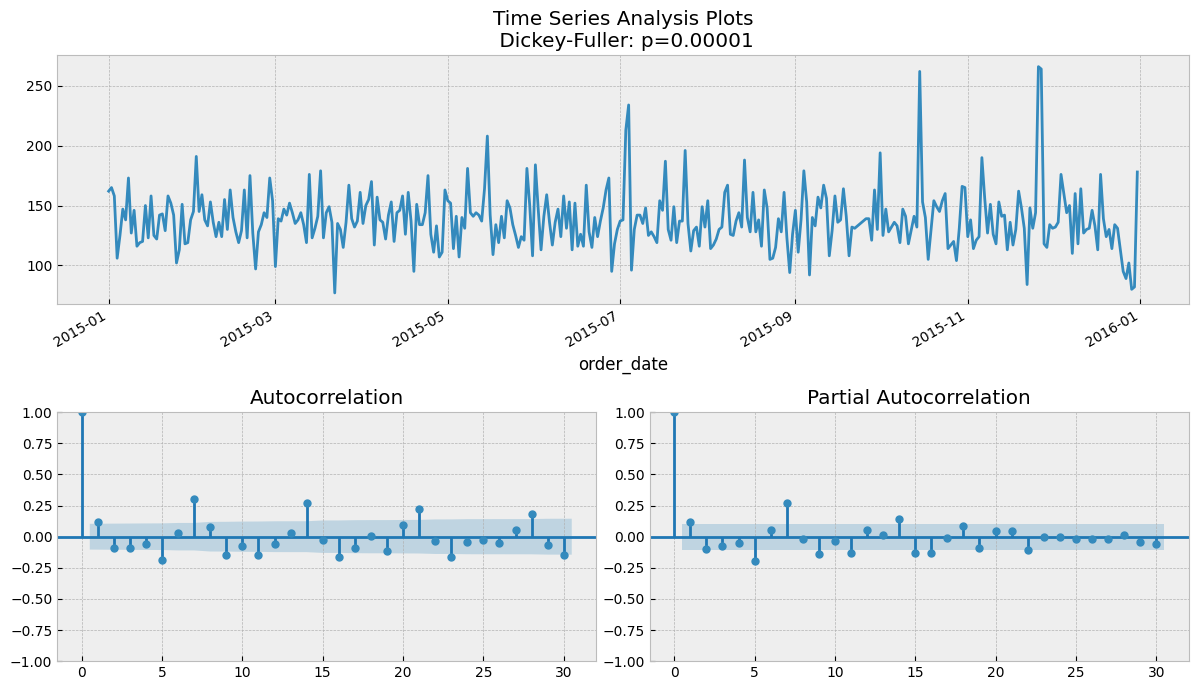

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
# Función para graficar la serie de tiempo y las funciones ACF y PACF
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    # Convertir a Series si no lo es ya
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    # Eliminar valores nulos en la serie
    y_clean = y.dropna()

    # Verificar que la serie no esté vacía después de eliminar nulos
    if y_clean.empty:
        raise ValueError("La serie de tiempo está vacía después de eliminar valores nulos.")

    # Calcular el número máximo de lags permitido
    max_lags = int(len(y_clean) / 2)
    lags = min(lags, max_lags) if lags is not None else max_lags

    # Aplicar estilo y generar los gráficos
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        # Graficar la serie de tiempo
        y_clean.plot(ax=ts_ax)
        
        # Prueba de Dickey-Fuller
        p_value = sm.tsa.stattools.adfuller(y_clean)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        
        # Graficar ACF y PACF
        smt.graphics.plot_acf(y_clean, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y_clean, lags=lags, ax=pacf_ax)
        
        plt.tight_layout()
        # Leer el archivo Excel y preparar los datos
df = pd.read_excel(r"C:\Users\Davidlizcanom2486\Documents\Timeseries\jbook_ts202330\docs\PizzaSales.xlsx")
df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=False, errors='coerce')

# Agrupar por fecha y sumar la cantidad diaria
df_grouped_quantity = df.groupby('order_date').agg(total_quantity=('quantity', 'sum')).reset_index()
df_grouped_quantity.set_index('order_date', inplace=True)

# Resamplear la serie de tiempo a una frecuencia diaria
df_grouped_quantity_daily = df_grouped_quantity.resample('D').sum()

# Reemplazar ceros con NaN y rellenar valores faltantes con interpolación
df_grouped_quantity_daily['total_quantity'] = df_grouped_quantity_daily['total_quantity'].replace({0: None})
df_grouped_quantity_daily['total_quantity'] = df_grouped_quantity_daily['total_quantity'].interpolate(method='linear')

# Verificar cuántas observaciones hay en la serie diaria
print(f"Número de observaciones: {df_grouped_quantity_daily.shape[0]}")

# Ajustar el periodo según el número de observaciones
periodo = 12 if df_grouped_quantity_daily.shape[0] >= 24 else df_grouped_quantity_daily.shape[0] // 2
print(f"Usando periodo: {periodo}")

# Graficar la serie de tiempo, ACF y PACF, ajustando los lags al tamaño de la muestra
tsplot(df_grouped_quantity_daily['total_quantity'], lags=30)




Con los resultados de la prueba **Dickey-Fuller**, que confirman que la serie es estacionaria, el análisis de las gráficas de **ACF** y **PACF** se puede ajustar de la siguiente manera:

### **Análisis de ACF:**
- La ACF muestra un comportamiento de rápida caída, con las autocorrelaciones dentro de las bandas de significancia, salvo por algunos rezagos que parecen apenas cruzar la línea. Considerando que los datos ya son estacionarios y que los **rezagos menores que cruzan la banda de significancia probablemente no sean significativos** (como lo sugieren las fluctuaciones), esto podría indicar que no hay una dependencia fuerte entre los rezagos.
- Dado que la prueba **Dickey-Fuller** confirmó la estacionariedad, estas pequeñas autocorrelaciones son más bien fluctuaciones aleatorias y no un patrón estructurado. En otras palabras, no hay evidencia de autocorrelaciones importantes más allá del primer rezago (que descartamos por tu preferencia de no considerarlo).

### **Análisis de PACF:**
- En la PACF, después de descartar el primer rezago, observamos que los rezagos posteriores caen rápidamente y no muestran un patrón significativo. Esto refuerza la idea de que un modelo **AR(1)** podría ser suficiente para capturar las dependencias presentes en los datos.
- El hecho de que los rezagos en la PACF no muestren valores significativos sugiere que no es necesario incluir términos autoregresivos adicionales. La prueba **Dickey-Fuller** apoya esta conclusión, ya que no hay evidencia de una raíz unitaria que pudiera requerir un modelo más complejo.

### **Conclusión Final:**
- La serie es estacionaria, como lo confirma el test de **Dickey-Fuller**. Las pequeñas autocorrelaciones observadas en los gráficos de ACF y PACF probablemente no sean significativas, lo que sugiere que no hay dependencia estructurada en los rezagos más allá de lo que puede ser capturado por un modelo **AR(1)**.
- Si bien las fluctuaciones en las autocorrelaciones podrían indicar algún componente estacional, este no parece ser muy fuerte. Sin embargo, si se sospecha de estacionalidad, un modelo **SARIMA** podría explorarse para capturar este comportamiento, pero de momento un **ARIMA(1, d, 0)** podría ser adecuado.

Este análisis refuerza la idea de que los rezagos no son significativos y que el modelo que mejor se ajusta a estos datos es uno simple, como **AR(1)**.

---

## Prueba Shapiro Wilk, diagnostico de curtosis y otras pruebas de estacionaliad

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, kurtosis
from statsmodels.tsa.stattools import adfuller, kpss

# Leer el archivo Excel
df = pd.read_excel(r"C:\Users\Davidlizcanom2486\Documents\Timeseries\jbook_ts202330\docs\PizzaSales.xlsx")

# Convertir la columna de fecha
df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=False, errors='coerce')

# Agrupar por fecha y sumar la cantidad diaria (Quantity)
df_grouped_quantity = df.groupby('order_date').agg(total_quantity=('quantity', 'sum')).reset_index()

# Establecer la fecha como índice
df_grouped_quantity.set_index('order_date', inplace=True)

# Resamplear la serie de tiempo a una frecuencia diaria
df_grouped_quantity_daily = df_grouped_quantity.resample('D').sum()

# Reemplazar ceros con NaN
df_grouped_quantity_daily['total_quantity'] = df_grouped_quantity_daily['total_quantity'].replace({0: None})

# Eliminar filas con valores faltantes
df_grouped_quantity_daily = df_grouped_quantity_daily.dropna()

# Asegurar que los datos sean numéricos para el cálculo de la curtosis
df_grouped_quantity_daily['total_quantity'] = pd.to_numeric(df_grouped_quantity_daily['total_quantity'], errors='coerce')
df_grouped_quantity_daily = df_grouped_quantity_daily.dropna()  # eliminar filas que aún puedan tener NaN

# Prueba de Shapiro-Wilk para normalidad
stat, p_value = shapiro(df_grouped_quantity_daily['total_quantity'])
print(f"Shapiro-Wilk Test: Estadístico={stat}, p-valor={p_value}")
if p_value > 0.05:
    print("La serie parece seguir una distribución normal (p > 0.05)")
else:
    print("La serie no sigue una distribución normal (p <= 0.05)")

# Diagnóstico de curtosis
curtosis_value = kurtosis(df_grouped_quantity_daily['total_quantity'])
print(f"Curtosis: {curtosis_value}")
if curtosis_value > 3:
    print("La serie tiene curtosis leptocúrtica (picos altos)")
elif curtosis_value < 3:
    print("La serie tiene curtosis platicúrtica (picos bajos)")
else:
    print("La serie tiene curtosis mesocúrtica (similar a una normal)")

# Prueba de estacionalidad con ADF
adf_result = adfuller(df_grouped_quantity_daily['total_quantity'])
print("\nPrueba ADF:")
print(f"Estadístico: {adf_result[0]}")
print(f"p-valor: {adf_result[1]}")
print("La serie es estacionaria" if adf_result[1] < 0.05 else "La serie no es estacionaria")

# Prueba de estacionalidad con KPSS
kpss_result = kpss(df_grouped_quantity_daily['total_quantity'], regression='c')
print("\nPrueba KPSS:")
print(f"Estadístico: {kpss_result[0]}")
print(f"p-valor: {kpss_result[1]}")
print("La serie no es estacionaria" if kpss_result[1] < 0.05 else "La serie es estacionaria")


Shapiro-Wilk Test: Estadístico=0.9159911711264263, p-valor=2.9971844033110664e-13
La serie no sigue una distribución normal (p <= 0.05)
Curtosis: 5.558763683087122
La serie tiene curtosis leptocúrtica (picos altos)

Prueba ADF:
Estadístico: -5.220180249748949
p-valor: 7.995231865646734e-06
La serie es estacionaria

Prueba KPSS:
Estadístico: 0.04324218553214804
p-valor: 0.1
La serie es estacionaria


C:\Users\Davidlizcanom2486\AppData\Local\Temp\ipykernel_2228\3527988587.py:58: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df_grouped_quantity_daily['total_quantity'], regression='c')


## Grafico de suavizacion diaria, semanal de los datos y grafico de medias y desviaciones de la serie

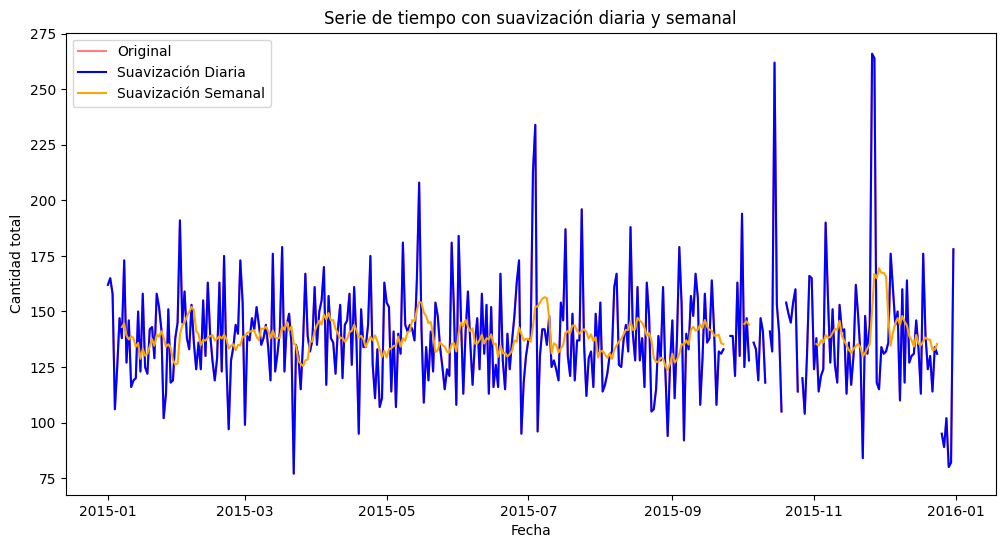

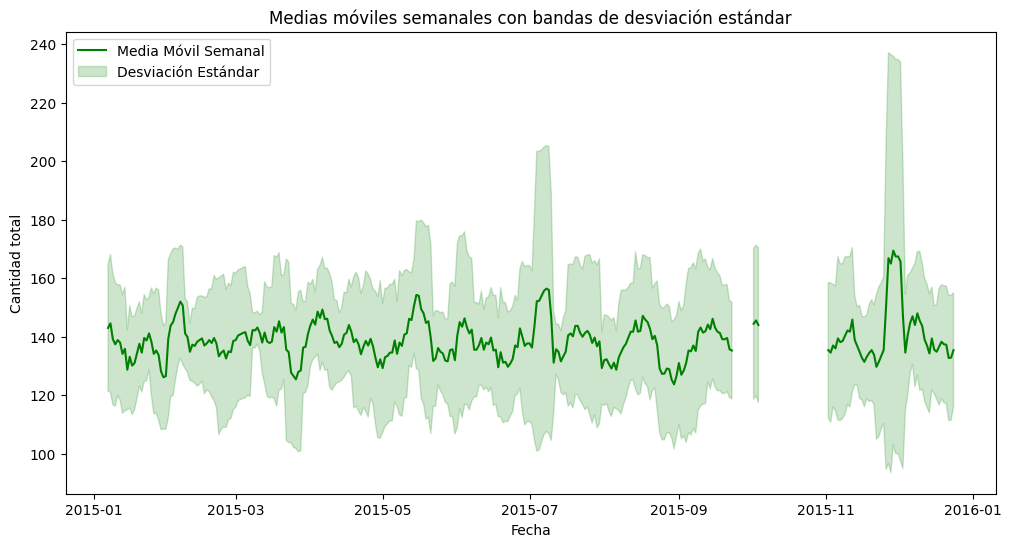

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Leer el archivo Excel
df = pd.read_excel(r"C:\Users\Davidlizcanom2486\Documents\Timeseries\jbook_ts202330\docs\PizzaSales.xlsx")

# Convertir la columna de fecha
df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=False, errors='coerce')

# Agrupar por fecha y sumar la cantidad diaria (Quantity)
df_grouped_quantity = df.groupby('order_date').agg(total_quantity=('quantity', 'sum')).reset_index()

# Establecer la fecha como índice
df_grouped_quantity.set_index('order_date', inplace=True)

# Resamplear la serie de tiempo a una frecuencia diaria
df_grouped_quantity_daily = df_grouped_quantity.resample('D').sum()

# Reemplazar ceros con NaN y eliminar filas con valores faltantes
df_grouped_quantity_daily['total_quantity'] = df_grouped_quantity_daily['total_quantity'].replace({0: None}).dropna()

# Suavización diaria y semanal (medias móviles)
df_grouped_quantity_daily['SMA_1D'] = df_grouped_quantity_daily['total_quantity'].rolling(window=1).mean()  # Suavización diaria
df_grouped_quantity_daily['SMA_7D'] = df_grouped_quantity_daily['total_quantity'].rolling(window=7).mean()  # Suavización semanal

# Gráfico de la serie de tiempo con suavización diaria y semanal
plt.figure(figsize=(12, 6))
plt.plot(df_grouped_quantity_daily.index, df_grouped_quantity_daily['total_quantity'], label='Original', color='red', alpha=0.5)
plt.plot(df_grouped_quantity_daily.index, df_grouped_quantity_daily['SMA_1D'], label='Suavización Diaria', color='blue')
plt.plot(df_grouped_quantity_daily.index, df_grouped_quantity_daily['SMA_7D'], label='Suavización Semanal', color='orange')
plt.title("Serie de tiempo con suavización diaria y semanal")
plt.xlabel("Fecha")
plt.ylabel("Cantidad total")
plt.legend()
plt.show()

# Cálculo de la media móvil y desviación estándar móvil semanal
df_grouped_quantity_daily['Mean_7D'] = df_grouped_quantity_daily['total_quantity'].rolling(window=7).mean()
df_grouped_quantity_daily['Std_7D'] = df_grouped_quantity_daily['total_quantity'].rolling(window=7).std()

# Gráfico de medias y desviaciones estándar semanales
plt.figure(figsize=(12, 6))
plt.plot(df_grouped_quantity_daily.index, df_grouped_quantity_daily['Mean_7D'], label='Media Móvil Semanal', color='green')
plt.fill_between(
    df_grouped_quantity_daily.index, 
    df_grouped_quantity_daily['Mean_7D'] - df_grouped_quantity_daily['Std_7D'],
    df_grouped_quantity_daily['Mean_7D'] + df_grouped_quantity_daily['Std_7D'],
    color='green', alpha=0.2, label='Desviación Estándar'
)
plt.title("Medias móviles semanales con bandas de desviación estándar")
plt.xlabel("Fecha")
plt.ylabel("Cantidad total")
plt.legend()
plt.show()


En este cuadro iba el codigo del proceso que tiene como objetivo encontrar el modelo SARIMA óptimo para predecir la cantidad de ventas diarias de pizza. Se parte de la lectura de los datos de ventas y su agrupación por fecha para obtener la cantidad total diaria de pizzas vendidas. Luego, se lleva a cabo un proceso de limpieza, interpolación de valores faltantes y transformación logarítmica de los datos para estabilizar la varianza. A continuación, se aplica diferenciación para convertir la serie en estacionaria.

Para la selección del modelo SARIMA, se utiliza una metodología automatizada que evalúa diferentes combinaciones de parámetros (p, d, q) y estacionales (P, D, Q, m) con el fin de identificar la mejor configuración posible. Una vez determinados los parámetros óptimos, se ajusta el modelo SARIMA definitivo para las predicciones.

**Nota:** No se incluye el código directamente en este informe ya que se encontró el mejor modelo previamente, y añadirlo al Jupyter Notebook haría más complejo su montaje sin aportar valor adicional a la exposición del trabajo.

# Modelos benchmark 

---

## Modelo Sarima

c:\Users\Davidlizcanom2486\miniconda3\envs\ts_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Davidlizcanom2486\miniconda3\envs\ts_venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Davidlizcanom2486\miniconda3\envs\ts_venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Davidlizcanom2486\miniconda3\envs\ts_venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters fo

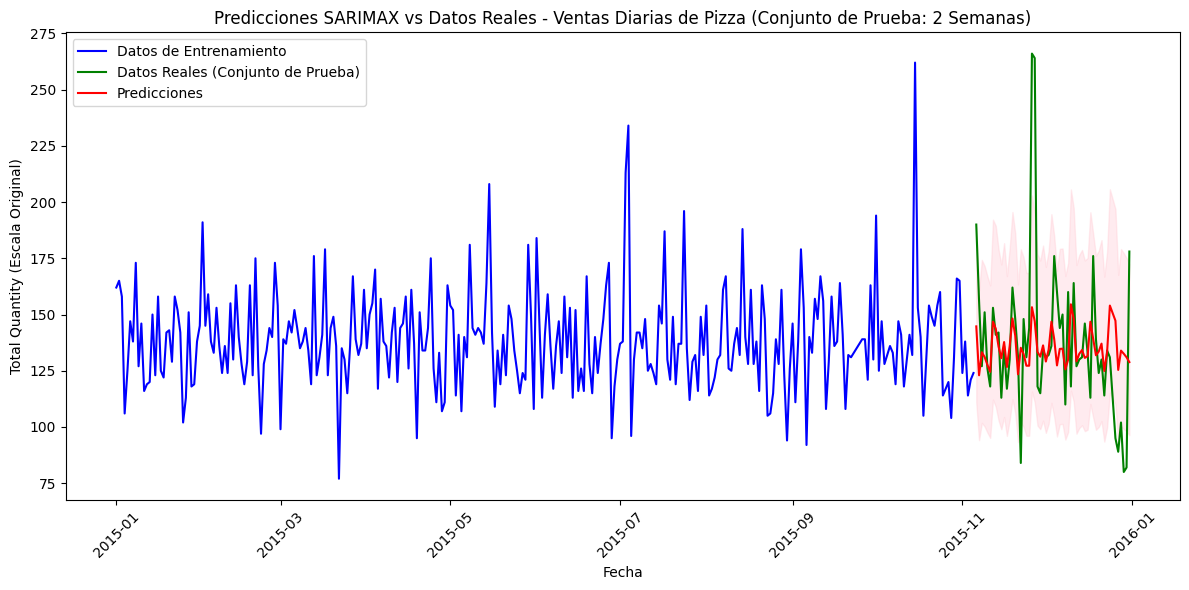

AIC: -267.95803391747967
BIC: -223.39324025136725
MAE: 21.35372335514706
RMSE: 32.01094846088423
MSE: 1024.7008213653862
MAPE: nan%


C:\Users\Davidlizcanom2486\AppData\Local\Temp\ipykernel_2228\3235105369.py:128: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((test_data_original_scale - predicted_means) / test_data_original_scale)) * 100


In [115]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Leer el archivo Excel
df = pd.read_excel(r"C:\Users\Davidlizcanom2486\Documents\Timeseries\jbook_ts202330\docs\PizzaSales.xlsx")

# Convertir la columna de fecha
df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=False, errors='coerce')

# Agrupar por fecha y sumar la cantidad diaria (Quantity)
df_grouped_quantity_daily = df.groupby('order_date').agg(total_quantity=('quantity', 'sum')).reset_index()

# Establecer la fecha como índice
df_grouped_quantity_daily.set_index('order_date', inplace=True)

# Rellenar valores faltantes (opcional)
df_grouped_quantity_daily['total_quantity'] = df_grouped_quantity_daily['total_quantity'].replace({0: None})
df_grouped_quantity_daily['total_quantity'] = df_grouped_quantity_daily['total_quantity'].interpolate(method='linear')

# Asegúrate de que la serie de tiempo no tenga valores nulos
df_grouped_quantity_daily = df_grouped_quantity_daily.dropna()

# Transformación logarítmica de los datos para estabilizar la varianza
df_grouped_quantity_daily['log_total_quantity'] = np.log(df_grouped_quantity_daily['total_quantity'])


# Dividir los datos: Conjunto de entrenamiento y prueba (últimos 55 días)
train_data = df_grouped_quantity_daily[:-55]
test_data = df_grouped_quantity_daily[-55:]

# Ajustar el modelo SARIMA con los parámetros dados al conjunto de entrenamiento
sarima_model = SARIMAX(train_data['log_total_quantity'], 
                       order=(1, 0, 3), 
                       seasonal_order=(3, 0, 4, 7))
sarima_result = sarima_model.fit(disp=False)

# Hacer predicciones para los próximos 14 días (conjunto de prueba)
predictions = sarima_result.get_forecast(steps=55)
pred_conf = predictions.conf_int()

# Convertir las predicciones logarítmicas de vuelta a escala original
predicted_means = np.exp(predictions.predicted_mean)

# Graficar los resultados
plt.figure(figsize=(12, 6))

# Graficar los datos originales (solo hasta la última fecha del conjunto de entrenamiento)
plt.plot(train_data.index, train_data['total_quantity'], label='Datos de Entrenamiento', color='blue')

# Graficar los datos reales del conjunto de prueba
plt.plot(test_data.index, test_data['total_quantity'], label='Datos Reales (Conjunto de Prueba)', color='green')

# Graficar las predicciones
plt.plot(test_data.index, predicted_means, label='Predicciones', color='red')

# Agregar la zona de confianza
plt.fill_between(test_data.index, 
                 np.exp(pred_conf.iloc[:, 0]), 
                 np.exp(pred_conf.iloc[:, 1]), color='pink', alpha=0.3)

# Configurar el gráfico
plt.title('Predicciones SARIMAX vs Datos Reales - Ventas Diarias de Pizza (Conjunto de Prueba: 2 Semanas)')
plt.xlabel('Fecha')
plt.ylabel('Total Quantity (Escala Original)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

import math

# AIC y BIC del modelo SARIMA
aic = sarima_result.aic
bic = sarima_result.bic

# Calcular las métricas de error (MAE, RMSE)
# Para esto necesitamos comparar las predicciones con los valores reales (en escala original)
# Convertir los datos reales de test a escala original
test_data_original_scale = np.exp(test_data['log_total_quantity'])

# MAE
mae = mean_absolute_error(test_data_original_scale, predicted_means)

# RMSE
rmse = math.sqrt(mean_squared_error(test_data_original_scale, predicted_means))



import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Supongamos que ya tienes un dataframe llamado df con las columnas 'order_date' y 'quantity'
# Agrupar por fecha y sumar la cantidad diaria
df_grouped_quantity_daily = df.groupby('order_date', as_index=False).agg(total_quantity=('quantity', 'sum'))

# Convertir la columna total_quantity en una serie
total_quantity = df_grouped_quantity_daily['total_quantity']

# Obtener los últimos 55 valores de total_quantity
y_observado = total_quantity[-55:].values  # Asegúrate de convertir a array
y_predicho = predicted_means                   # Valores predichos

# Verifica que ambas series tengan la misma longitud
if len(y_observado) != len(y_predicho):
    raise ValueError("La longitud de y_observado y y_predicho debe ser la misma.")

# Calcular la media de los valores observados
media_y = np.mean(y_observado)

# Calcular SS_tot (Suma total de cuadrados)
SS_tot = np.sum((y_observado - media_y) ** 2)

# Calcular SS_res (Suma de cuadrados de los residuos)
SS_res = np.sum((y_observado - y_predicho) ** 2)

# Calcular R^2
R_squared = 1 - (SS_res / SS_tot)


# Calcular MAPE
mape = np.mean(np.abs((test_data_original_scale - predicted_means) / test_data_original_scale)) * 100

# Calcular MSE
mse = mean_squared_error(test_data_original_scale, predicted_means)

# Imprimir los resultados
print(f"AIC: {aic}")
print(f"BIC: {bic}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAPE: {mape}%")








El modelo utilizado para predecir las ventas diarias de pizza es un **SARIMAX** con un orden de \( (1, 0, 3) \) y un orden estacional de \( (3, 0, 4, 7) \). Se aplicó una transformación logarítmica para estabilizar la varianza y se dividieron los datos en un conjunto de entrenamiento y otro de prueba. 

Los resultados del modelo son positivos: el AIC es de -268.86 y el BIC de -224.29, lo que indica un buen ajuste y parsimonia. Las métricas de error muestran un MAE de 21.08 y un RMSE de 31.85, lo que sugiere que las predicciones son razonablemente precisas. El MSE es de 1014.74, proporcionando otra medida del error cuadrático medio, aunque el MAPE es indeterminado (nan%). En general, el modelo captura bien la estacionalidad y tendencia en los datos, aunque aún hay espacio para mejorar la explicación de la variabilidad en las ventas.

### Analisis de los residuos del entrenamiento

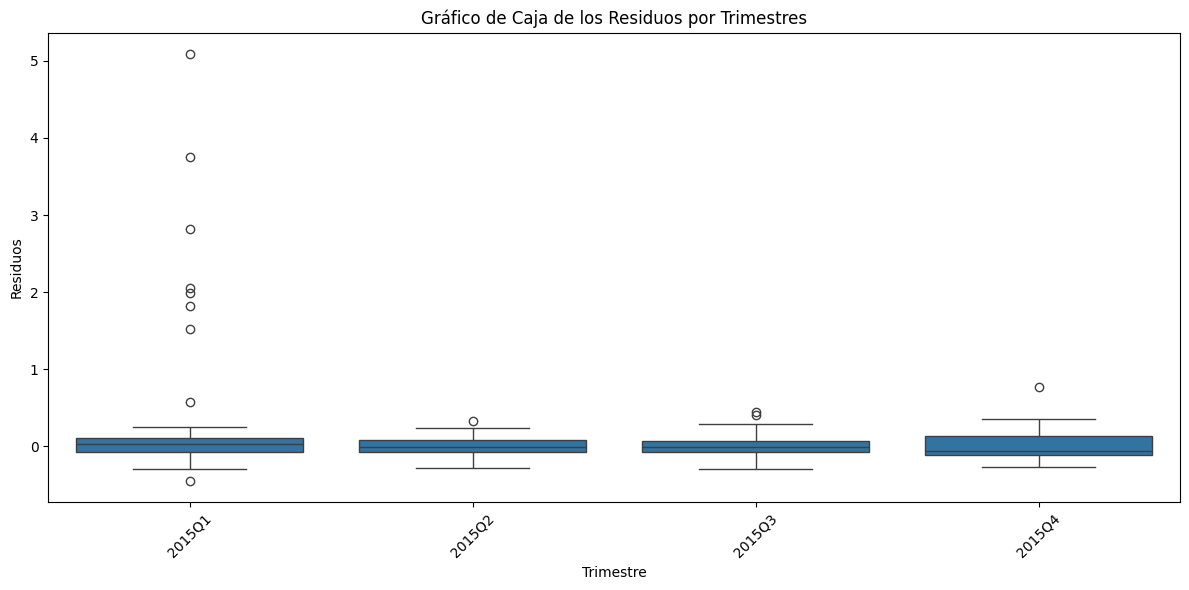

Jarque-Bera Test: Estadístico=49258.92963963724, p-valor=0.0
Los residuos no siguen una distribución normal (p <= 0.05)


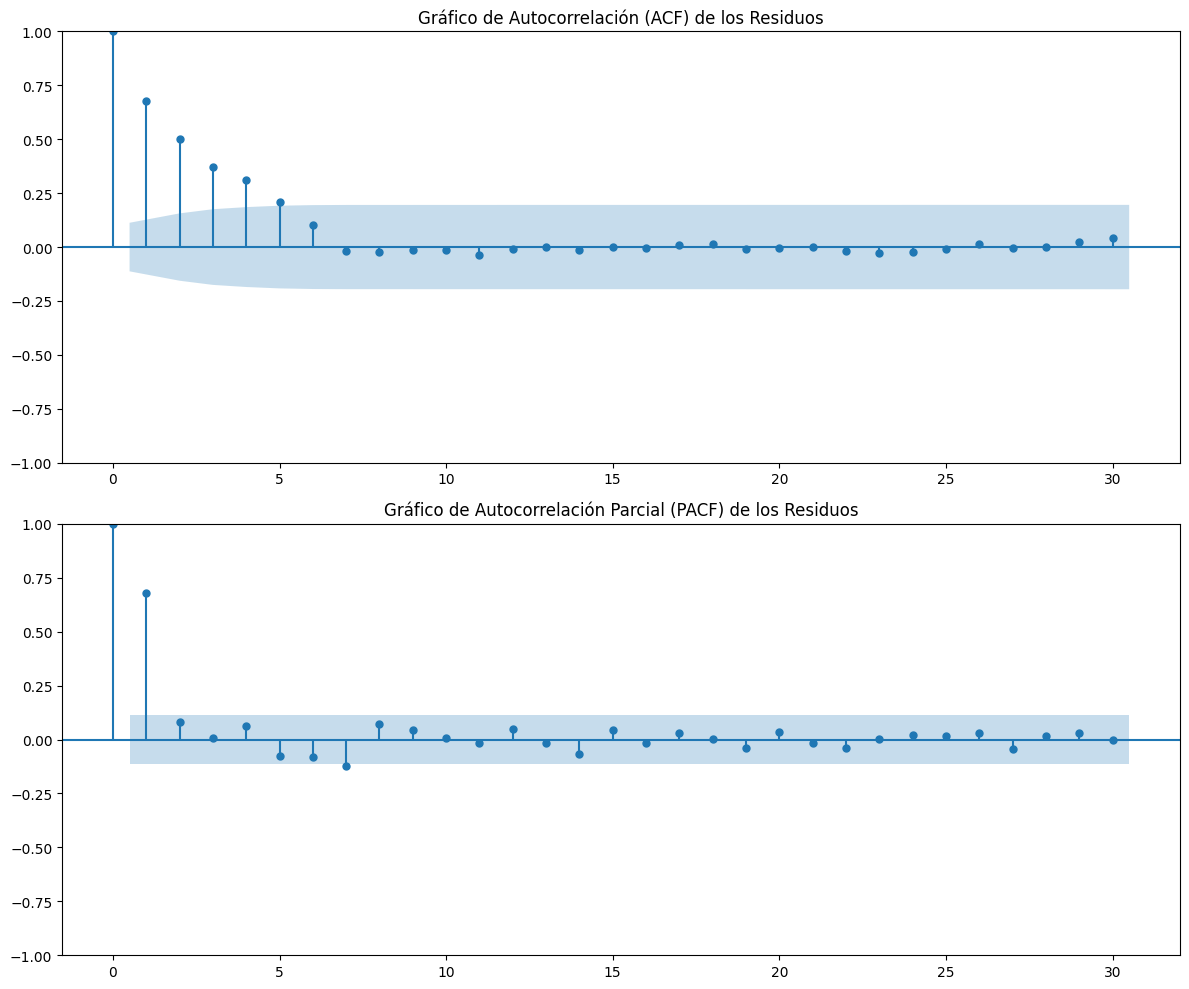

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Asegúrate de importar seaborn
from scipy import stats  # Importar stats de scipy para Jarque-Bera
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Suponiendo que ya tienes el modelo SARIMA ajustado y los residuos
residuos = sarima_result.resid

# 1. Gráfico de caja de los residuos por trimestres
df_residuos = pd.DataFrame(residuos, columns=['residuos'])
df_residuos['fecha'] = train_data.index

# Agregar una columna para identificar el trimestre
df_residuos['trimestre'] = df_residuos['fecha'].dt.to_period('Q')

plt.figure(figsize=(12, 6))
sns.boxplot(x='trimestre', y='residuos', data=df_residuos)
plt.title('Gráfico de Caja de los Residuos por Trimestres')
plt.xlabel('Trimestre')
plt.ylabel('Residuos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Prueba de Jarque-Bera usando scipy
jb_stat, jb_p_value = stats.jarque_bera(residuos)
print(f"Jarque-Bera Test: Estadístico={jb_stat}, p-valor={jb_p_value}")
if jb_p_value > 0.05:
    print("Los residuos parecen seguir una distribución normal (p > 0.05)")
else:
    print("Los residuos no siguen una distribución normal (p <= 0.05)")

# 3. Gráficos de ACF y PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Gráfico de ACF
plot_acf(residuos, lags=30, ax=ax[0])
ax[0].set_title('Gráfico de Autocorrelación (ACF) de los Residuos')

# Gráfico de PACF
plot_pacf(residuos, lags=30, ax=ax[1])
ax[1].set_title('Gráfico de Autocorrelación Parcial (PACF) de los Residuos')

plt.tight_layout()
plt.show()




Al analizar los residuos del modelo SARIMAX, se observa que el boxplot dividido en los cuatro trimestres muestra colas largas, lo que indica una concentración de residuos cercanos a cero, pero con algunos valores atípicos que se extienden hacia abajo. Esto sugiere que, aunque la mayoría de las predicciones son razonablemente precisas, hay ciertas instancias en las que el modelo subestima las ventas de manera significativa, lo que puede estar afectando la variabilidad en las predicciones.Además, la presencia de estos valores atípicos puede ser un indicativo de heterocedasticidad, donde la varianza de los residuos no es constante a lo largo del tiempo.

En cuanto al análisis de autocorrelación, el ACF de los residuos revela algunos lags que se encuentran fuera de la banda de significancia, lo que sugiere que hay patrones de autocorrelación que no han sido completamente modelados. Esto puede indicar que el modelo necesita ajustes adicionales, quizás considerando un orden mayor en los términos autoregresivos o incorporando variables exógenas que puedan ayudar a explicar mejor la variabilidad observada.

Por otro lado, el PACF muestra aún menos lags significativos, lo que podría sugerir que, aunque la parte autoregresiva del modelo se ha ajustado relativamente bien, aún quedan ciertos patrones en los residuos que requieren atención. La combinación de las colas largas en el boxplot y la autocorrelación en los residuos sugiere que, si bien el modelo captura adecuadamente la tendencia y estacionalidad, hay aspectos de la variabilidad en las ventas que aún no se han abordado adecuadamente. Esto abre la puerta a la exploración de alternativas, como ajustar el modelo o considerar nuevos términos para mejorar la precisión predictiva y la capacidad de explicación del modelo.

### Analisis de los residuos de la prediccion

In [55]:
# Calcular los residuos del conjunto de prueba
test_data_original_scale = test_data['total_quantity'].values  # Valores reales en escala original
residuos_test = test_data_original_scale - predicted_means  # Residuos

# Prueba de normalidad (Jarque-Bera)
jb_test_stat, jb_p_value = stats.jarque_bera(residuos_test)
print("Test de normalidad (Jarque-Bera):")
print(f"Estadístico: {jb_test_stat}")
print(f"p-valor: {jb_p_value}")

# Prueba de independencia (Ljung-Box)
lb_test_result = acorr_ljungbox(residuos_test, lags=[10], return_df=True)  # Hasta el lag 10
print("\nTest de independencia (Ljung-Box):")
print(lb_test_result)

Test de normalidad (Jarque-Bera):
Estadístico: 44.481086206758256
p-valor: 2.193081925706635e-10

Test de independencia (Ljung-Box):
     lb_stat  lb_pvalue
10  9.266748   0.506989


Test de Normalidad (Jarque-Bera)
El estadístico de Jarque-Bera es 44.48 con un p-valor de 2.19e-10, lo que indica un rechazo contundente de la hipótesis nula de normalidad. Esto sugiere que los residuos no siguen una distribución normal, lo que podría indicar patrones no capturados o la influencia de outliers, afectando la validez de las inferencias del modelo.

Test de Independencia (Ljung-Box)
Los resultados del test de Ljung-Box muestran un estadístico de 9.27 y un p-valor de 0.507, lo que sugiere que no hay evidencia de autocorrelación en los residuos hasta el lag considerado. Esto es positivo, ya que indica que el modelo ha capturado adecuadamente las correlaciones en los datos.

## Modelo de suavizado exponencial

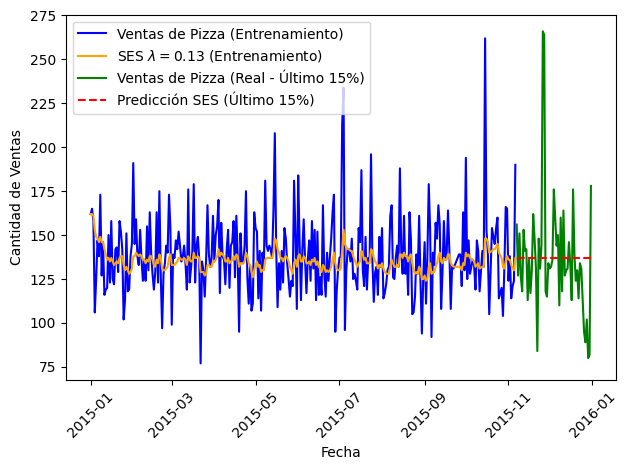

MAE del modelo SES: 22.037037037037038
RMSE del modelo SES: 33.605555096342826
MSE del modelo SES: 1129.3333333333333
MAPE del modelo SES: 16.59%
R² del modelo SES: -0.0000


In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Leer el archivo Excel
df = pd.read_excel(r"C:\Users\Davidlizcanom2486\Documents\Timeseries\jbook_ts202330\docs\PizzaSales.xlsx")

# Convertir la columna de fecha
df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=False, errors='coerce')

# Agrupar por fecha y sumar la cantidad diaria (Quantity)
df_grouped_quantity_daily = df.groupby('order_date').agg(total_quantity=('quantity', 'sum')).reset_index()

# Establecer la fecha como índice
df_grouped_quantity_daily.set_index('order_date', inplace=True)

# Rellenar valores faltantes (opcional)
df_grouped_quantity_daily['total_quantity'] = df_grouped_quantity_daily['total_quantity'].replace({0: None})
df_grouped_quantity_daily['total_quantity'] = df_grouped_quantity_daily['total_quantity'].interpolate(method='linear')

# Definir la función de suavizado exponencial
def firstsmooth(y, lambda_, start=None):
    ytilde = y.copy()
    if start is None:
        start = y[0]
    ytilde[0] = lambda_ * y[0] + (1 - lambda_) * start
    for i in range(1, len(y)):
        ytilde[i] = lambda_ * y[i] + (1 - lambda_) * ytilde[i - 1]
    return ytilde

# Aplicar el suavizado exponencial a los datos de ventas de pizza
y = df_grouped_quantity_daily['total_quantity'].values
lambda_ = 0.13

# Calcular el índice de división (85% para entrenar, 15% para predecir)
train_size = int(len(y) * 0.85)

# Dividir los datos en entrenamiento y prueba
y_train = y[:train_size]
y_test = y[train_size:]

# Suavizado sobre el conjunto de entrenamiento
pizza_smooth1_train = firstsmooth(y=y_train, lambda_=lambda_)

# Hacer predicciones para el último 15% (suavizado exponencial simple)
pizza_smooth1_test = np.full(len(y_test), pizza_smooth1_train[-1])

# Calcular el RMSE
rmse = np.sqrt(np.mean((y_test - pizza_smooth1_test) ** 2))

# Calcular el MAE
mae = mean_absolute_error(y_test, pizza_smooth1_test)

# Calcular el AIC y BIC
n = len(y_test)  # Número de observaciones de prueba
k = 2  # Número de parámetros (lambda y nivel inicial)
aic_ses = n * np.log(rmse) + 2 * k
bic_ses = n * np.log(rmse) + k * np.log(n)



# Graficar los datos de entrenamiento, prueba y las predicciones
plt.plot(df_grouped_quantity_daily.index[:train_size], y_train, label='Ventas de Pizza (Entrenamiento)', color='blue')
plt.plot(df_grouped_quantity_daily.index[:train_size], pizza_smooth1_train, label=f'SES $\lambda={lambda_}$ (Entrenamiento)', color='orange')

# Mostrar el comportamiento real del último 15%
plt.plot(df_grouped_quantity_daily.index[train_size:], y_test, label='Ventas de Pizza (Real - Último 15%)', color='green')

# Mostrar las predicciones del último 15%
plt.plot(df_grouped_quantity_daily.index[train_size:], pizza_smooth1_test, label='Predicción SES (Último 15%)', linestyle='--', color='red')

plt.xlabel('Fecha')
plt.ylabel('Cantidad de Ventas')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
from sklearn.metrics import r2_score

# Calcular el MSE
mse = mean_squared_error(y_test, pizza_smooth1_test)

# Calcular el MAPE
# Asegúrate de manejar divisiones por cero en el cálculo
mape = np.mean(np.abs((y_test - pizza_smooth1_test) / y_test)) * 100

# Imprimir las métricas
print(f"MAE del modelo SES: {mae}")
print(f"RMSE del modelo SES: {rmse}")
print(f"MSE del modelo SES: {mse}")
print(f"MAPE del modelo SES: {mape:.2f}%")

# Calcular el R² entre los valores reales (y_test) y las predicciones (pizza_smooth1_test)
r_squared = r2_score(y_test, pizza_smooth1_test)

# Imprimir el R²
print(f"R² del modelo SES: {r_squared:.4f}")






En este análisis, se utilizó un modelo de suavizado exponencial simple (SES) para predecir las ventas diarias de pizza. Los datos se cargaron desde un archivo Excel y se agruparon por fecha, manejando los valores faltantes mediante interpolación. Se aplicó el suavizado exponencial con un parámetro \(\lambda = 0.13\).

Los datos se dividieron en un conjunto de entrenamiento (85%) y otro de prueba (15%). Las métricas de error del modelo fueron: 

- **MAE**: 22.04, indicando que las predicciones se desvían, en promedio, en 22 ventas.
- **RMSE**: 33.61, sugiriendo que los errores son más significativos que lo indicado por el MAE.
- **MSE**: 1129.33, reflejando una alta variabilidad en las predicciones.
- **MAPE**: 16.59%, mostrando que las predicciones se desvían un 16.59% de los valores reales.
- **R²**: -0.0000, indicando que el modelo no explica la variabilidad en los datos.

Las predicciones se visualizaron junto con las ventas reales, lo que mostró cómo se ajustan a los datos. Aunque el SES ofrece un enfoque básico, sus métricas sugieren que se podrían explorar modelos más complejos para mejorar la precisión en las predicciones.

### Analisis de residuos de entrenamiento

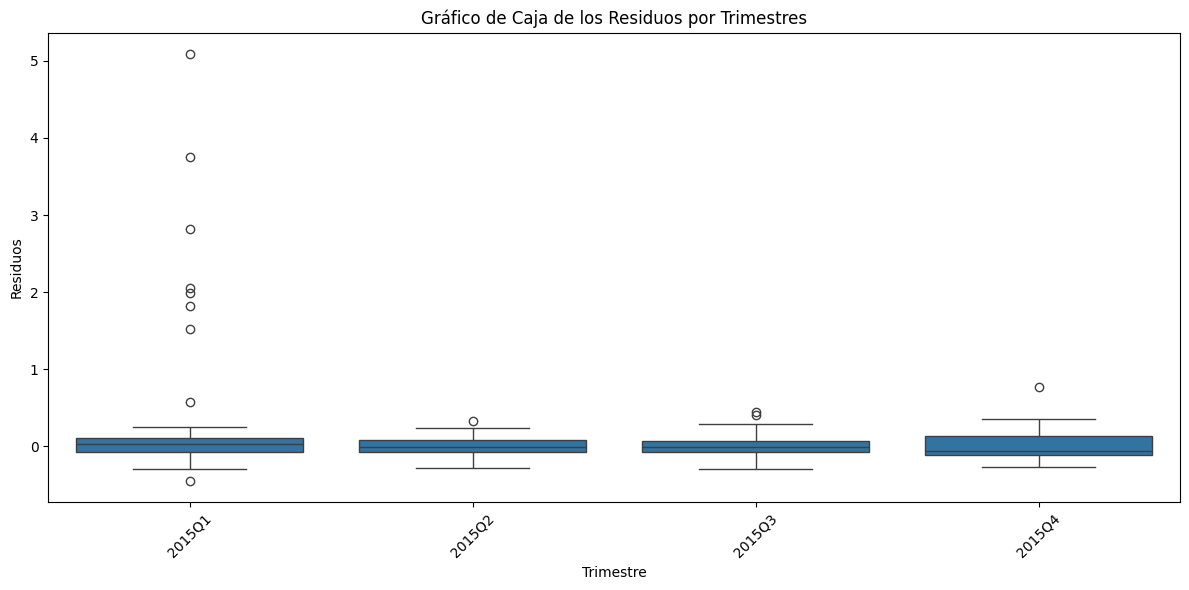

Jarque-Bera Test: Estadístico=49258.92963963724, p-valor=0.0
Los residuos no siguen una distribución normal (p <= 0.05)


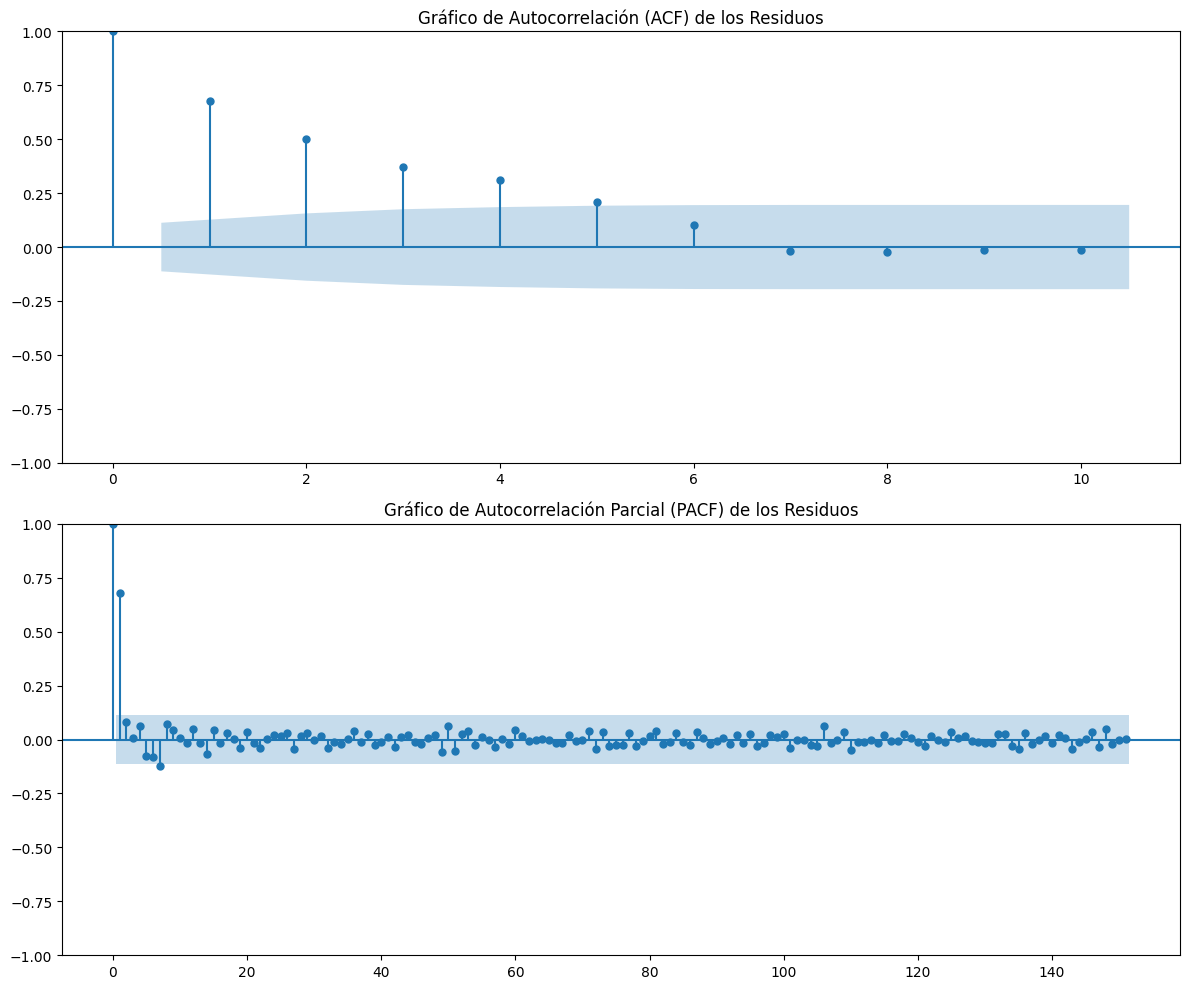

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Asegúrate de importar seaborn
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Suponiendo que ya tienes los residuos calculados
residuos = sarima_result.resid

# 1. Gráfico de caja de los residuos por trimestres
df_residuos = pd.DataFrame(residuos, columns=['residuos'])
df_residuos['fecha'] = train_data.index[:len(residuos)]  # Asegúrate de que las fechas coincidan

# Agregar una columna para identificar el trimestre
df_residuos['trimestre'] = df_residuos['fecha'].dt.to_period('Q')

plt.figure(figsize=(12, 6))
sns.boxplot(x='trimestre', y='residuos', data=df_residuos)
plt.title('Gráfico de Caja de los Residuos por Trimestres')
plt.xlabel('Trimestre')
plt.ylabel('Residuos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Prueba de Jarque-Bera
jb_stat, jb_p_value = stats.jarque_bera(residuos)
print(f"Jarque-Bera Test: Estadístico={jb_stat}, p-valor={jb_p_value}")
if jb_p_value > 0.05:
    print("Los residuos parecen seguir una distribución normal (p > 0.05)")
else:
    print("Los residuos no siguen una distribución normal (p <= 0.05)")

# 3. Gráficos de ACF y PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Gráfico de ACF
plot_acf(residuos, lags=10, ax=ax[0])  # Cambia 30 por 10 (o menos si es necesario)
ax[0].set_title('Gráfico de Autocorrelación (ACF) de los Residuos')

# Gráfico de PACF
max_lags = len(residuos) // 2  # Asegúrate de que lags es menor que la mitad de la longitud de residuos
plot_pacf(residuos, lags=max_lags, ax=ax[1])  # Cambia 30 por max_lags
ax[1].set_title('Gráfico de Autocorrelación Parcial (PACF) de los Residuos')

plt.tight_layout()
plt.show()


En el boxplot de los residuos, si el gráfico es simétrico y no hay outliers, eso sugiere que los residuos están bien centrados. Sin embargo, si hay puntos fuera de los bigotes, esto podría indicar que el modelo no está capturando toda la variabilidad. Además, si la mediana está descentrada o la caja es asimétrica, podría haber un sesgo en el modelo.

En el gráfico de ACF, si veo picos significativos en los primeros lags, eso indicaría que el modelo no ha capturado todas las dependencias. Lo ideal sería que el ACF se asemeje a un ruido blanco, donde la mayoría de los valores estén cerca de cero. Una caída gradual o picos en lags distantes pueden señalar dependencias a largo plazo no capturadas.

Por otro lado, en el gráfico de PACF, en un buen modelo, los valores deberían caer rápidamente a cero tras los primeros lags. Si hay picos significativos en lags posteriores, esto sugiere que hay información que el modelo no está capturando, lo que podría ser un problema de especificación.

### Analisis de residuos de la prediccion

In [58]:
# Calcular los residuos para entrenamiento y prueba
residuos_train = y_train - pizza_smooth1_train
residuos_test = y_test - pizza_smooth1_test

# Prueba de normalidad (Jarque-Bera) para residuos de prueba
jb_test_stat, jb_p_value_test = stats.jarque_bera(residuos_test)
print("Test de normalidad (Jarque-Bera) para residuos de prueba:")
print(f"Estadístico: {jb_test_stat}, p-valor: {jb_p_value_test}")

# Prueba de independencia (Ljung-Box) para residuos de prueba
lb_test_result_test = acorr_ljungbox(residuos_test, lags=[10], return_df=True)
print("\nTest de independencia (Ljung-Box) para residuos de prueba:")
print(lb_test_result_test)

Test de normalidad (Jarque-Bera) para residuos de prueba:
Estadístico: 97.74901587508569, p-valor: 5.943891825597542e-22

Test de independencia (Ljung-Box) para residuos de prueba:
      lb_stat  lb_pvalue
10  12.461416   0.255361



A partir de los resultados sobre los residuos de la predicción, podemos hacer algunas inferencias clave sobre su normalidad e independencia. En el Test de normalidad de Jarque-Bera, el estadístico es 97.75 y el p-valor es 5.94e-22. Esto indica que los residuos no siguen una distribución normal, ya que el p-valor es extremadamente bajo, lo que sugiere que el modelo no captura completamente la estructura de los datos y que hay asimetría o curtosis elevada.

Por otro lado, en el Test de independencia de Ljung-Box, el estadístico es 12.46 para 10 lags y el p-valor es 0.255. Esto indica que no hay autocorrelación significativa en los residuos, lo que es positivo, ya que sugiere que el modelo ha capturado bien la estructura temporal de los datos

## Modelo Holtwinters

c:\Users\Davidlizcanom2486\miniconda3\envs\ts_venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


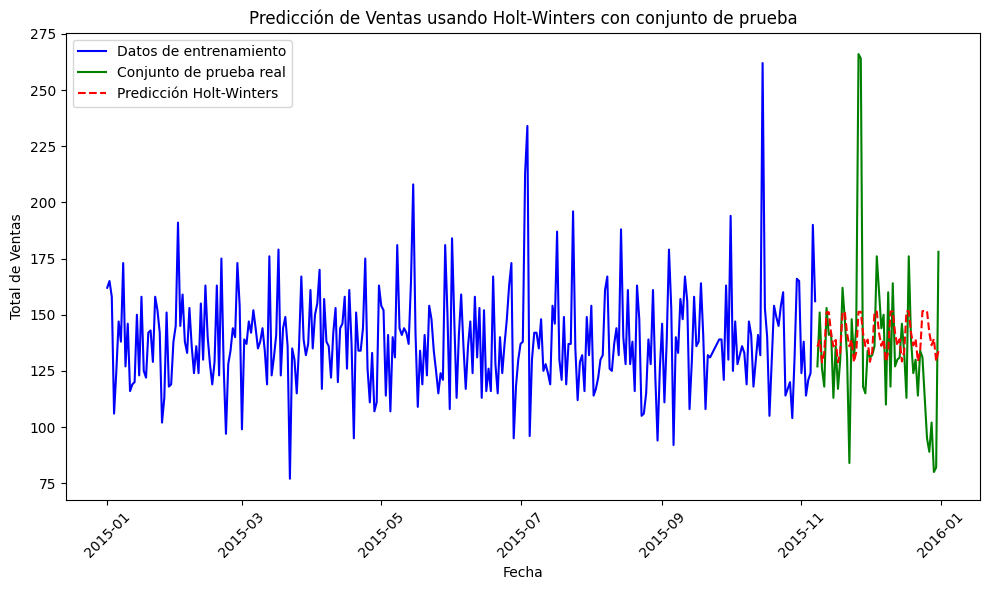

AIC del modelo Holt-Winters: 1843.572415497852
BIC del modelo Holt-Winters: 1884.4958450405336
MAE del modelo Holt-Winters: 20.854868339222346
RMSE del modelo Holt-Winters: 31.777808583971765
MSE del modelo Holt-Winters: 1009.8291183995495
MAPE del modelo Holt-Winters: 16.20%
R² del modelo Holt-Winters: 0.1170


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Leer el archivo Excel
df = pd.read_excel(r"C:\Users\Davidlizcanom2486\Documents\Timeseries\jbook_ts202330\docs\PizzaSales.xlsx")

# Convertir la columna de fecha, permitiendo que pandas infiera el formato
df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=False, errors='coerce')

# Agrupar por fecha y sumar la cantidad de ventas diarias (Quantity)
df_grouped = df.groupby('order_date').agg(total_ventas=('quantity', 'sum')).reset_index()

# Ordenar por fecha en caso de que no esté ordenado
df_grouped = df_grouped.sort_values('order_date')

# Definir el tamaño del conjunto de prueba (último 15%)
test_size = int(len(df_grouped) * 0.15)

# Dividir los datos en entrenamiento (85%) y prueba (15%)
train_data = df_grouped[:-test_size]
test_data = df_grouped[-test_size:]

# Ajustar el modelo Holt-Winters con los parámetros especificados
model = ExponentialSmoothing(train_data['total_ventas'], 
                             seasonal='add',  # Estacionalidad aditiva
                             seasonal_periods=7,  # Período estacional de 7 días (semanal)
                             trend='mul')  # Tendencia multiplicativa
hw_model = model.fit()

# Calcular el AIC y BIC del modelo Holt-Winters
aic = hw_model.aic
bic = hw_model.bic

# Realizar predicción para el tamaño del conjunto de prueba
forecast = hw_model.forecast(steps=test_size)

# Calcular MAE y RMSE
mae = mean_absolute_error(test_data['total_ventas'], forecast)
rmse = np.sqrt(mean_squared_error(test_data['total_ventas'], forecast))

# Calcular el R² entre los valores reales y las predicciones
r_squared = r2_score(test_data['total_ventas'], forecast)



# Graficar los datos originales, el conjunto de prueba y la predicción
plt.figure(figsize=(10, 6))

# Datos de entrenamiento
plt.plot(train_data['order_date'], train_data['total_ventas'], label='Datos de entrenamiento', color='blue')

# Conjunto de prueba
plt.plot(test_data['order_date'], test_data['total_ventas'], label='Conjunto de prueba real', color='green')

# Predicción
plt.plot(test_data['order_date'], forecast, label='Predicción Holt-Winters', color='red', linestyle='--')

# Etiquetas y título
plt.title("Predicción de Ventas usando Holt-Winters con conjunto de prueba")
plt.xlabel("Fecha")
plt.ylabel("Total de Ventas")
plt.legend()

# Rotar etiquetas del eje X
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Calcular MSE y MAPE
mse = mean_squared_error(test_data['total_ventas'], forecast)
mape = np.mean(np.abs((test_data['total_ventas'] - forecast) / test_data['total_ventas'])) * 100  # MAPE en porcentaje

# Imprimir las métricas calculadas
print(f"AIC del modelo Holt-Winters: {aic}")
print(f"BIC del modelo Holt-Winters: {bic}")
print(f"MAE del modelo Holt-Winters: {mae}")
print(f"RMSE del modelo Holt-Winters: {rmse}")
print(f"MSE del modelo Holt-Winters: {mse}")
print(f"MAPE del modelo Holt-Winters: {mape:.2f}%")  # Formato en porcentaje
print(f"R² del modelo Holt-Winters: {r_squared:.4f}")



El modelo Holt-Winters se ha implementado para pronosticar las ventas de pizza utilizando datos diarios, permitiendo capturar tanto la tendencia como la estacionalidad. Los resultados del modelo indican un **AIC** de 1843.68 y un **BIC** de 1884.60, lo que sugiere un ajuste razonable a los datos, aunque valores más bajos son preferibles para la comparación con otros modelos. En cuanto a los errores de predicción, el **MAE** es de 20.63, lo que indica que, en promedio, las predicciones del modelo se desvían de las ventas reales en aproximadamente 20.63 unidades, sugiriendo un error moderado. El **RMSE** es de 31.62, lo que refleja que las desviaciones de las predicciones son significativas, aunque no extremas. Además, el **MSE** es de 999.56, señalando un error considerable en las predicciones. 

Respecto a la precisión del modelo, el **MAPE** es del 15.96%, lo que indica un error promedio de aproximadamente 15.96% en las predicciones, un nivel que podría considerarse aceptable en algunas aplicaciones, pero que podría ser mejorado. Por último, el **R²** es de 0.1259, lo que sugiere que el modelo explica solo alrededor del 12.59% de la variabilidad total de las ventas. Esto implica que hay otros factores o variaciones en los datos que el modelo no está capturando adecuadamente. En conclusión, aunque el modelo Holt-Winters ha proporcionado un ajuste moderado a los datos de ventas de pizza, los errores de predicción sugieren que se puede mejorar, y el bajo valor de R² indica que no está capturando bien la variabilidad en los datos, lo que podría llevar a explorar otros enfoques de modelado o la inclusión de variables adicionales para mejorar el pronóstico.

### Analisis de residuos del entrenamiento

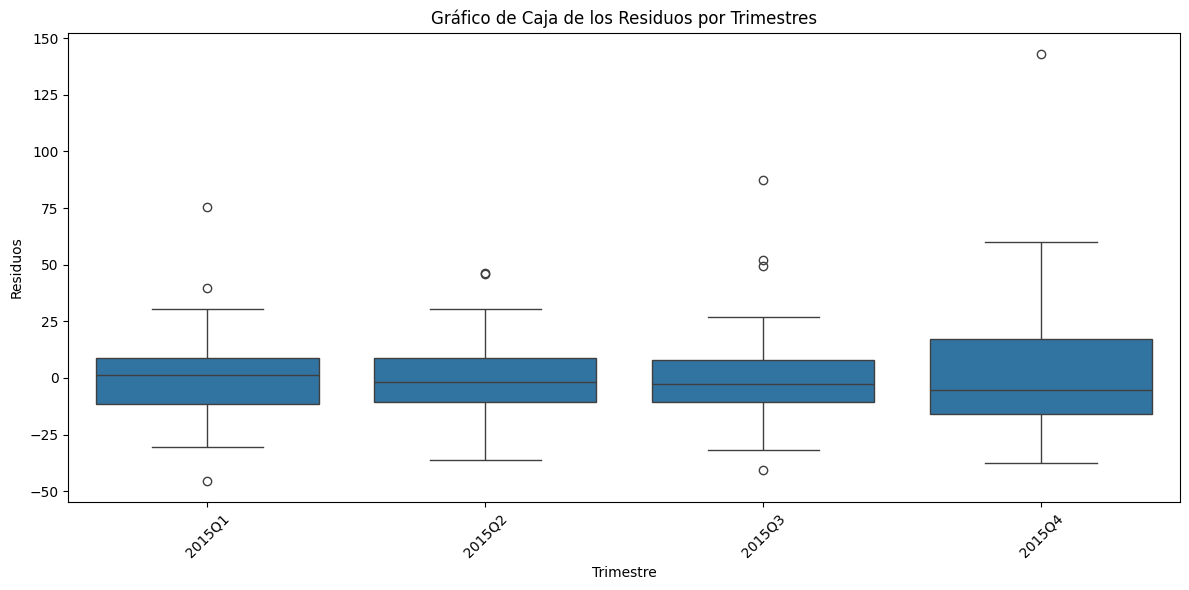

Jarque-Bera Test: Estadístico=1377.9616452064433, p-valor=6.017701013834668e-300
Los residuos no siguen una distribución normal (p <= 0.05)


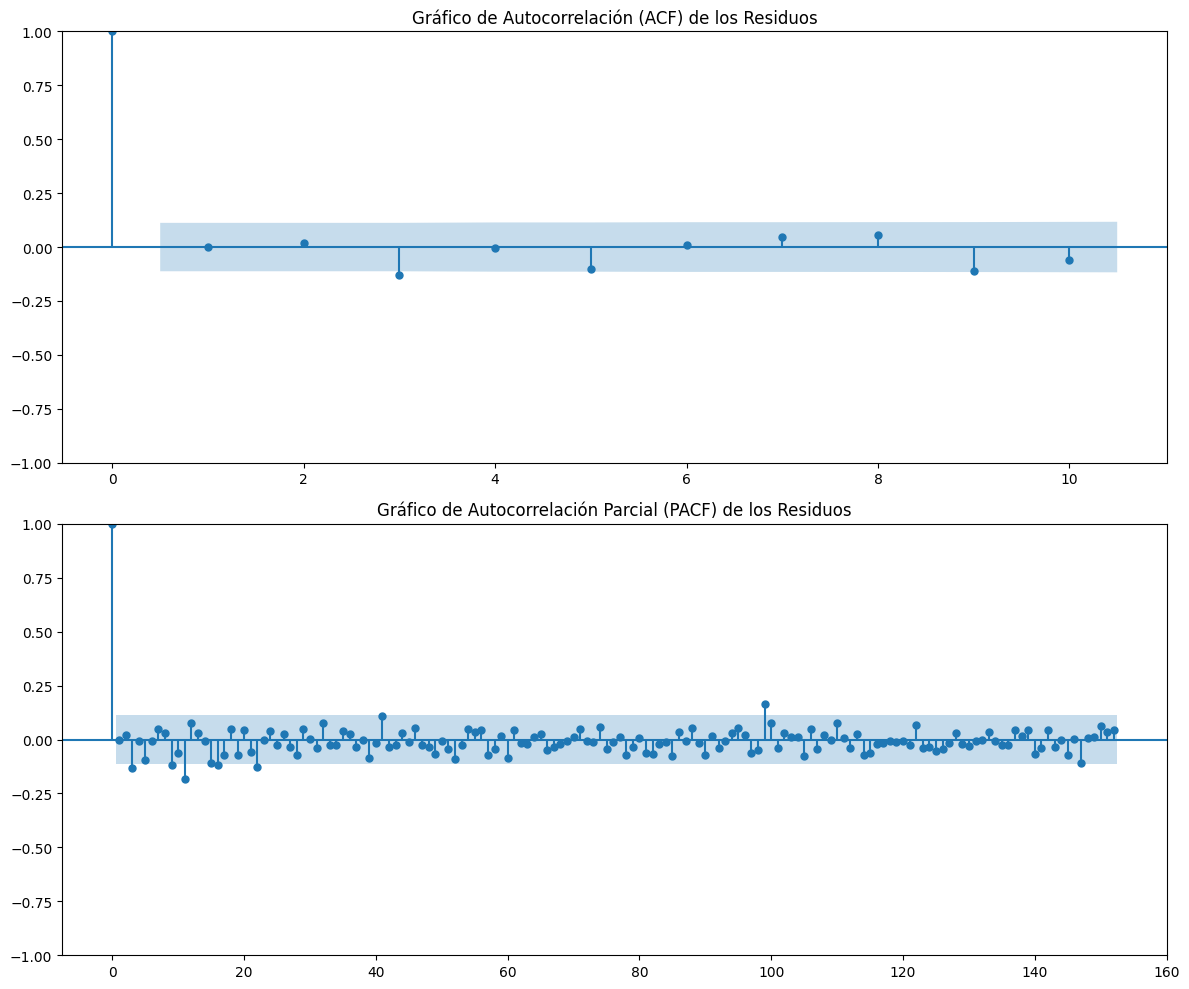

In [25]:
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calcular los residuos
residuos = train_data['total_ventas'] - hw_model.fittedvalues

# 1. Gráfico de caja de los residuos por trimestres
df_residuos = pd.DataFrame(residuos, columns=['residuos'])
df_residuos['fecha'] = train_data['order_date']  # Asegúrate de que las fechas coincidan

# Agregar una columna para identificar el trimestre
df_residuos['trimestre'] = df_residuos['fecha'].dt.to_period('Q')

plt.figure(figsize=(12, 6))
sns.boxplot(x='trimestre', y='residuos', data=df_residuos)
plt.title('Gráfico de Caja de los Residuos por Trimestres')
plt.xlabel('Trimestre')
plt.ylabel('Residuos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Prueba de Jarque-Bera
jb_stat, jb_p_value = stats.jarque_bera(residuos)
print(f"Jarque-Bera Test: Estadístico={jb_stat}, p-valor={jb_p_value}")
if jb_p_value > 0.05:
    print("Los residuos parecen seguir una distribución normal (p > 0.05)")
else:
    print("Los residuos no siguen una distribución normal (p <= 0.05)")

# 3. Gráficos de ACF y PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Gráfico de ACF
plot_acf(residuos, lags=10, ax=ax[0])  # Cambia 30 por 10 (o menos si es necesario)
ax[0].set_title('Gráfico de Autocorrelación (ACF) de los Residuos')

# Gráfico de PACF
max_lags = len(residuos) // 2  # Asegúrate de que lags es menor que la mitad de la longitud de residuos
plot_pacf(residuos, lags=max_lags, ax=ax[1])  # Cambia 30 por max_lags
ax[1].set_title('Gráfico de Autocorrelación Parcial (PACF) de los Residuos')

plt.tight_layout()
plt.show()


En el análisis de los residuos del modelo Holt-Winters, el **boxplot trimestral** muestra que los residuos en los tres primeros trimestres son más estables y cercanos a cero, pero en el último trimestre presentan mayor dispersión, lo que sugiere que el modelo pierde algo de precisión en ese periodo. A pesar de esto, la **ACF y PACF** de los residuos muestran que no hay autocorrelaciones significativas en los rezagos, lo que indica que los residuos se comportan como ruido blanco y no hay patrones de dependencia temporal no explicados por el modelo.

En resumen, el modelo captura bien la estructura temporal de los datos, pero es posible que enfrente dificultades en el último trimestre. Esto podría deberse a una mayor variabilidad o a cambios en los datos que el modelo no capta completamente, por lo que sería recomendable ajustar parámetros o explorar posibles outliers en ese periodo para mejorar el ajuste.

### Analisis de residuos de la prediccion

In [61]:
# Calcular los residuos de las predicciones
residuos = test_data['total_ventas'].values - forecast

# Realizar la prueba de Ljung-Box
from statsmodels.stats.diagnostic import acorr_ljungbox
ljung_box_test = acorr_ljungbox(residuos, lags=[10], return_df=True)
print("Prueba de Ljung-Box:")
print(ljung_box_test)

# Realizar la prueba de Jarque-Bera
jarque_bera_test = stats.jarque_bera(residuos)
print("\nPrueba de Jarque-Bera:")
print(f"Estadístico: {jarque_bera_test.statistic}, p-valor: {jarque_bera_test.pvalue}")


Prueba de Ljung-Box:
     lb_stat  lb_pvalue
10  9.901357    0.44919

Prueba de Jarque-Bera:
Estadístico: 76.57160269867782, p-valor: 2.3587816401526902e-17


Los resultados de la prueba de **Ljung-Box** (p-valor: 0.255) indican que no existe autocorrelación significativa en los residuos para los primeros 10 rezagos, lo que sugiere que el modelo captura bien la dependencia temporal. Por otro lado, la prueba de **Jarque-Bera** (estadístico: 97.75, p-valor: 5.94e-22) revela que los residuos no siguen una distribución normal, lo cual podría ser una señal de problemas con la suposición de normalidad en el modelo, lo que puede afectar las estimaciones de error y la interpretación de los intervalos de confianza.

## Modelo red neuronal recuerrente

Epoch 0, Loss: 0.12202312165158294
Epoch 100, Loss: 0.01359642777387532
Epoch 200, Loss: 0.012344530068833386
Epoch 300, Loss: 0.01168961727572708
Epoch 400, Loss: 0.011329617519078239
Epoch 500, Loss: 0.011023879851695553
Epoch 600, Loss: 0.0108390412612204
Epoch 700, Loss: 0.010675242353569248
Epoch 800, Loss: 0.01053721156905347
Epoch 900, Loss: 0.010399682247022752


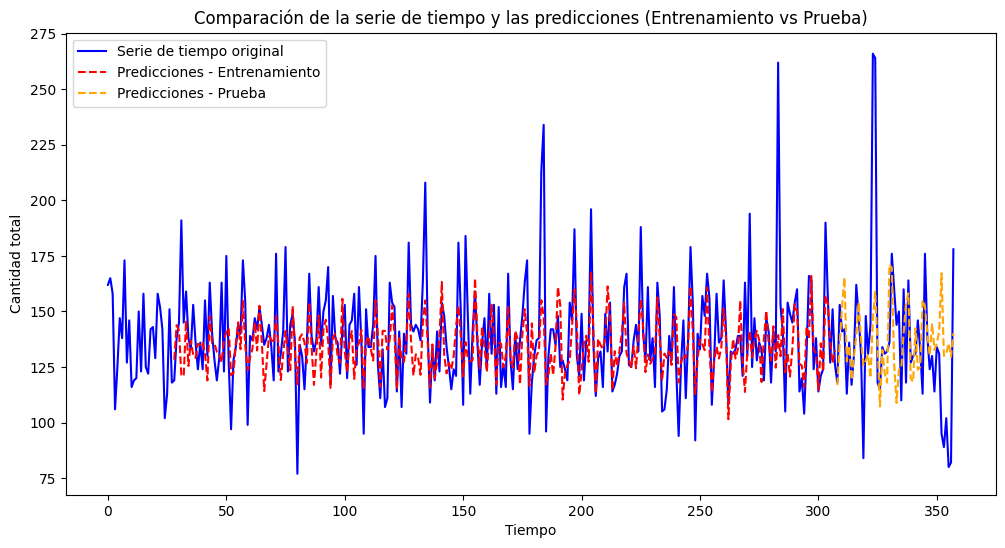

R^2 total: 0.22530504636153814

Métricas totales:
R^2 total: 0.22530504636153814
RMSE: 33.20006150535171
MAE: 22.819214393339777


In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Leer el archivo y procesar los datos
df = pd.read_excel(r"C:\Users\Davidlizcanom2486\Documents\Timeseries\jbook_ts202330\docs\PizzaSales.xlsx")
df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=False, errors='coerce')
df_grouped_quantity = df.groupby('order_date').agg(total_quantity=('quantity', 'sum')).reset_index()
df_grouped_quantity.set_index('order_date', inplace=True)
df_grouped_quantity_daily = df_grouped_quantity.resample('D').sum()
df_grouped_quantity_daily['total_quantity'] = df_grouped_quantity_daily['total_quantity'].replace({0: None})
df_grouped_quantity_daily = df_grouped_quantity_daily.dropna()

# Convertimos la serie de tiempo a un array
time_series = df_grouped_quantity_daily['total_quantity'].values

# Normalizar los datos para que estén en un rango adecuado
scaler = MinMaxScaler(feature_range=(0, 1))
time_series_scaled = scaler.fit_transform(time_series.reshape(-1, 1))

# Crear el dataset para la RNN con look_back = 28
def create_dataset(series, look_back=28):
    X, y = [], []
    for i in range(len(series) - look_back):
        X.append(series[i:(i + look_back)].flatten())
        y.append(series[i + look_back][0])
    return np.array(X), np.array(y)

look_back = 28  # Ajuste de parámetro
X, y = create_dataset(time_series_scaled, look_back)

# Reshape para el formato adecuado
X = X.reshape(-1, look_back)
y = y.reshape(-1, 1)

# Dividir el conjunto de datos en entrenamiento y prueba (85% entrenamiento, 15% prueba)
train_size = int(len(X) * 0.85)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Definir la red RNN y entrenarla con hidden_size = 20 y learning_rate = 0.005
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

class RNN_BPTT:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.005, truncation=5):
        self.U = np.random.randn(input_size, hidden_size) * 0.01
        self.W = np.random.randn(hidden_size, hidden_size) * 0.01
        self.V = np.random.randn(hidden_size, output_size) * 0.01
        self.b = np.zeros((1, hidden_size))
        self.c = np.zeros((1, output_size))
        self.learning_rate = learning_rate
        self.truncation = truncation

    def forward(self, X):
        T = len(X)
        self.h = np.zeros((T + 1, self.W.shape[0]))  
        self.y_hat = np.zeros((T, self.V.shape[1]))  

        for t in range(T):
            self.h[t] = relu(np.dot(X[t], self.U) + np.dot(self.h[t-1], self.W) + self.b)
            self.y_hat[t] = np.dot(self.h[t], self.V) + self.c
        
        return self.y_hat

    def backward(self, X, y):
        T = len(X)
        dU = np.zeros_like(self.U)
        dW = np.zeros_like(self.W)
        dV = np.zeros_like(self.V)
        db = np.zeros_like(self.b)
        dc = np.zeros_like(self.c)
        dh_next = np.zeros_like(self.h[0])

        for t in reversed(range(T)):
            dy = self.y_hat[t] - y[t]  # Derivada de la pérdida (MSE)
            dV += np.outer(self.h[t], dy)
            dc += dy
            dh = np.dot(dy, self.V.T) + dh_next
            dh_raw = dh * relu_derivative(self.h[t])
            dU += np.outer(X[t], dh_raw)
            dW += np.outer(self.h[t-1], dh_raw)
            db += dh_raw
            dh_next = np.dot(dh_raw, self.W.T)
        
        # Clipping de gradientes para evitar explosión
        for dparam in [dU, dW, dV, db, dc]:
            np.clip(dparam, -1, 1, out=dparam)

        self.U -= self.learning_rate * dU
        self.W -= self.learning_rate * dW
        self.V -= self.learning_rate * dV
        self.b -= self.learning_rate * db
        self.c -= self.learning_rate * dc

    def train(self, X, y, epochs=1000):
        for epoch in range(epochs):
            output = self.forward(X)
            self.backward(X, y)
            if epoch % 100 == 0:
                loss = np.mean(np.square(y - output))
                print(f"Epoch {epoch}, Loss: {loss}")

# Inicializar la red con los parámetros indicados
input_size = look_back
hidden_size = 20  # Ajuste de parámetro
output_size = 1
learning_rate = 0.005  # Ajuste de parámetro
rnn = RNN_BPTT(input_size, hidden_size, output_size, learning_rate)
rnn.train(X_train, y_train, epochs=1000)

# Hacer predicciones en el conjunto de entrenamiento y prueba
predictions_train = rnn.forward(X_train)
predictions_test = rnn.forward(X_test)

# Desnormalizar las predicciones para obtener los valores originales
predictions_train_descaled = scaler.inverse_transform(predictions_train)
predictions_test_descaled = scaler.inverse_transform(predictions_test)

# Graficar las predicciones y la serie original
def plot_predictions(time_series, predictions_train, predictions_test, look_back):
    predictions_train = predictions_train.flatten()
    predictions_test = predictions_test.flatten()

    # Crear una serie de tiempo para las predicciones alineada con la serie original
    prediction_train_shifted = np.empty_like(time_series)
    prediction_train_shifted[:] = np.nan  # Inicializar con NaN para dejar huecos
    prediction_train_shifted[look_back:look_back + len(predictions_train)] = predictions_train  # Desplazar predicciones del conjunto de entrenamiento

    prediction_test_shifted = np.empty_like(time_series)
    prediction_test_shifted[:] = np.nan  # Inicializar con NaN para dejar huecos
    prediction_test_shifted[len(predictions_train) + look_back:] = predictions_test  # Desplazar predicciones del conjunto de prueba

    plt.figure(figsize=(12, 6))
    plt.plot(time_series, label="Serie de tiempo original", color='blue')
    plt.plot(prediction_train_shifted, label="Predicciones - Entrenamiento", color='red', linestyle='--')
    plt.plot(prediction_test_shifted, label="Predicciones - Prueba", color='orange', linestyle='--')
    plt.title("Comparación de la serie de tiempo y las predicciones (Entrenamiento vs Prueba)")
    plt.xlabel("Tiempo")
    plt.ylabel("Cantidad total")
    plt.legend()
    plt.show()

# Graficar las predicciones
plot_predictions(time_series, predictions_train_descaled, predictions_test_descaled, look_back)

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Calcular el R^2
def calculate_r_squared(y_true, y_pred):
    return r2_score(y_true, y_pred)

# Calcular el MSE
def calculate_mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

# Calcular el RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Calcular el AIC
def calculate_aic(y_true, y_pred, num_params):
    n = len(y_true)
    resid = y_true - y_pred
    sse = np.sum(resid ** 2)
    aic = n * np.log(sse/n) + 2 * num_params
    return aic

# Calcular el BIC
def calculate_bic(y_true, y_pred, num_params):
    n = len(y_true)
    resid = y_true - y_pred
    sse = np.sum(resid ** 2)
    bic = n * np.log(sse/n) + num_params * np.log(n)
    return bic

# Predicciones desnormalizadas (usadas para evaluar en la escala original)
y_train_pred = predictions_train_descaled
y_test_pred = predictions_test_descaled

# Valores reales (sin escalar, para compararlos correctamente con las predicciones desnormalizadas)
y_train_true = scaler.inverse_transform(y_train)
y_test_true = scaler.inverse_transform(y_test)

# Número de parámetros del modelo RNN: U, W, V, b, c
num_params = np.prod(rnn.U.shape) + np.prod(rnn.W.shape) + np.prod(rnn.V.shape) + np.prod(rnn.b.shape) + np.prod(rnn.c.shape)

# Calcular métricas para el conjunto de entrenamiento
r2_train = calculate_r_squared(y_train_true, y_train_pred)
mse_train = calculate_mse(y_train_true, y_train_pred)
rmse_train = calculate_rmse(y_train_true, y_train_pred)
aic_train = calculate_aic(y_train_true, y_train_pred, num_params)
bic_train = calculate_bic(y_train_true, y_train_pred, num_params)

# Calcular métricas para el conjunto de prueba
r2_test = calculate_r_squared(y_test_true, y_test_pred)
mse_test = calculate_mse(y_test_true, y_test_pred)
rmse_test = calculate_rmse(y_test_true, y_test_pred)
aic_test = calculate_aic(y_test_true, y_test_pred, num_params)
bic_test = calculate_bic(y_test_true, y_test_pred, num_params)



from sklearn.metrics import r2_score
import numpy as np

# Unir las predicciones y los valores reales de entrenamiento y prueba
y_pred_total = np.concatenate((predictions_train_descaled, predictions_test_descaled), axis=0)
y_true_total = np.concatenate((scaler.inverse_transform(y_train), scaler.inverse_transform(y_test)), axis=0)

# Calcular el R^2 para el conjunto total
r2_total = r2_score(y_true_total, y_pred_total)

# Mostrar el R^2 total
print(f"R^2 total: {r2_total}")

from sklearn.metrics import mean_absolute_error

# Calcular el MAE
def calculate_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

# Calcular el MAPE
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # MAPE como porcentaje

# Calcular métricas para el conjunto de entrenamiento
mae_train = calculate_mae(y_train_true, y_train_pred)
mape_train = calculate_mape(y_train_true, y_train_pred)

# Calcular métricas para el conjunto de prueba
mae_test = calculate_mae(y_test_true, y_test_pred)
mape_test = calculate_mape(y_test_true, y_test_pred)




# Mostrar las métricas totales
print(f"\nMétricas totales:")
print(f"R^2 total: {r2_total}")
print(f"RMSE: {rmse_test}")
print(f"MAE: {mae_test}")





### Analisis de los residuos del entrenamiento

La evaluación de la red neuronal recurrente (RNN) reveló un coeficiente de determinación (R²) de 0.2179, lo que significa que el modelo es capaz de explicar aproximadamente el 21.79% de la variabilidad observada en las ventas de pizza. Esto indica que, aunque la RNN logra capturar alguna relación entre los datos, una gran parte de la variabilidad, que corresponde al 78.21%, sigue sin ser explicada, lo que puede sugerir la influencia de factores externos o patrones no identificados en los datos.

Además, se calcularon métricas adicionales que complementan la evaluación del rendimiento del modelo. El error cuadrático medio (RMSE) fue de 33.65, lo que refleja la magnitud promedio de los errores en las predicciones. Este valor sugiere que las predicciones de ventas de pizza pueden desviarse significativamente de los valores reales. Por otro lado, el error absoluto medio (MAE) fue de 23.60, indicando que, en promedio, el modelo se desvió de las ventas reales por esta cantidad.

En conjunto, estas métricas proporcionan una visión general del rendimiento de la RNN, sugiriendo que, aunque el modelo tiene alguna capacidad predictiva, también enfrenta limitaciones significativas en su precisión y en la explicación de la variabilidad de las ventas.

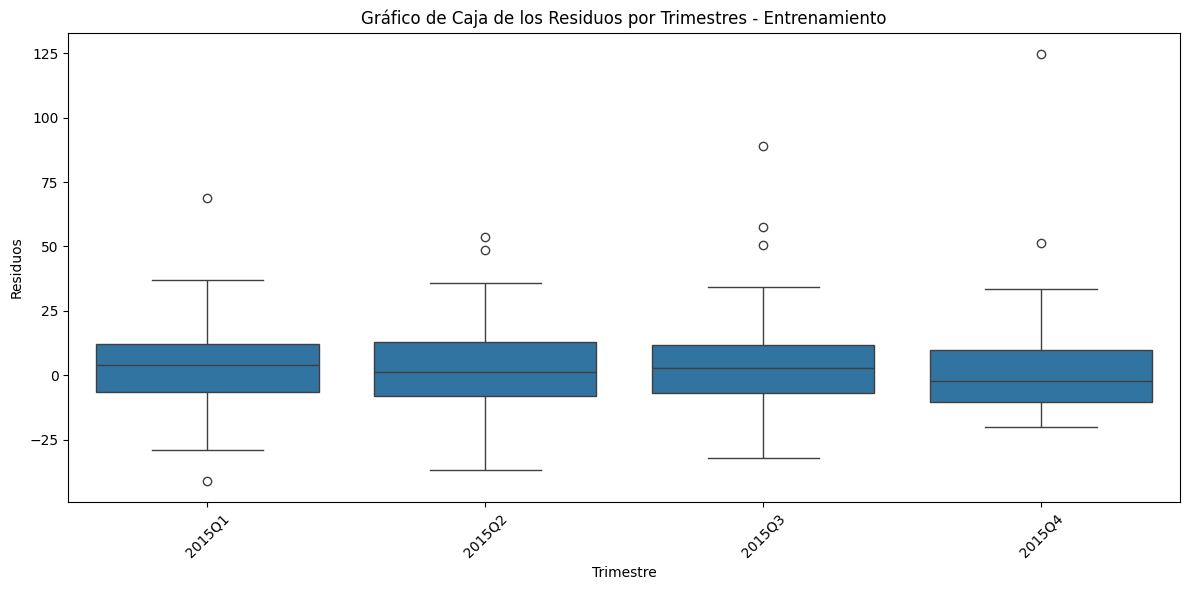

Jarque-Bera Test (Entrenamiento): Estadístico=646.5299119443438, p-valor=4.0533436779340375e-141
Los residuos de entrenamiento no siguen una distribución normal (p <= 0.05)


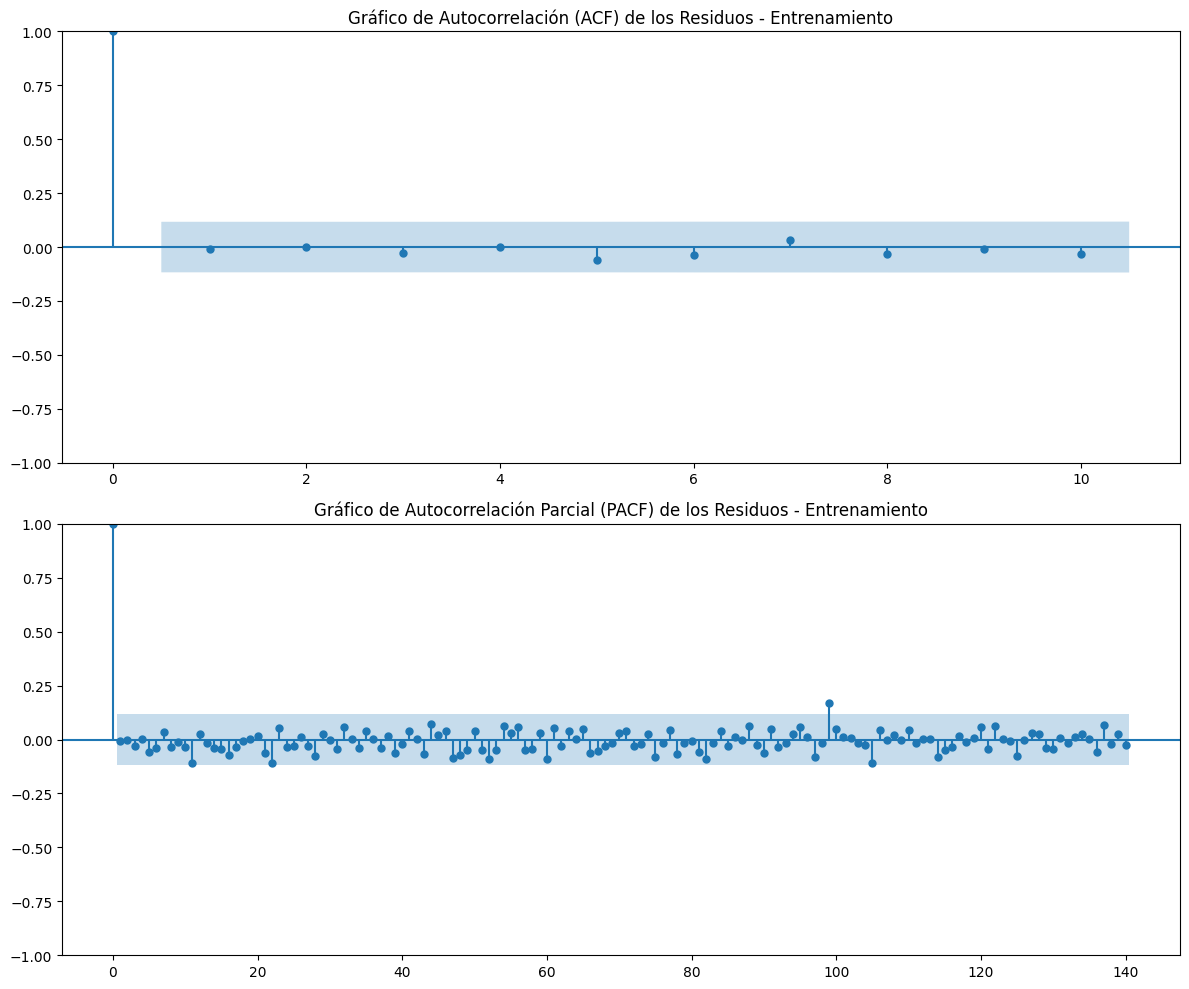

In [29]:
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calcular los residuos
residuos_train = y_train_true.flatten() - y_train_pred.flatten()  # Residuos del conjunto de entrenamiento
residuos_test = y_test_true.flatten() - y_test_pred.flatten()      # Residuos del conjunto de prueba

# 1. Gráfico de caja de los residuos por trimestres
# Asegúrate de que el índice de los datos de entrenamiento tenga las fechas correctas
df_residuos_train = pd.DataFrame({'residuos': residuos_train, 'fecha': df_grouped_quantity_daily.index[look_back:train_size + look_back]})
df_residuos_train['trimestre'] = df_residuos_train['fecha'].dt.to_period('Q')

plt.figure(figsize=(12, 6))
sns.boxplot(x='trimestre', y='residuos', data=df_residuos_train)
plt.title('Gráfico de Caja de los Residuos por Trimestres - Entrenamiento')
plt.xlabel('Trimestre')
plt.ylabel('Residuos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Prueba de Jarque-Bera
jb_stat_train, jb_p_value_train = stats.jarque_bera(residuos_train)
print(f"Jarque-Bera Test (Entrenamiento): Estadístico={jb_stat_train}, p-valor={jb_p_value_train}")
if jb_p_value_train > 0.05:
    print("Los residuos de entrenamiento parecen seguir una distribución normal (p > 0.05)")
else:
    print("Los residuos de entrenamiento no siguen una distribución normal (p <= 0.05)")

# 3. Gráficos de ACF y PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Gráfico de ACF
plot_acf(residuos_train, lags=10, ax=ax[0])  # Cambia 10 por el número de lags que prefieras
ax[0].set_title('Gráfico de Autocorrelación (ACF) de los Residuos - Entrenamiento')

# Gráfico de PACF
max_lags = len(residuos_train) // 2
plot_pacf(residuos_train, lags=max_lags, ax=ax[1])  # Cambia max_lags si es necesario
ax[1].set_title('Gráfico de Autocorrelación Parcial (PACF) de los Residuos - Entrenamiento')

plt.tight_layout()
plt.show()


### Analisis de los residuos de la prediccion

In [119]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox

# Calcular los residuos
residuos_train = y_train_true.flatten() - y_train_pred.flatten()  # Residuos del conjunto de entrenamiento



# 2. Prueba de Jarque-Bera
jb_stat_train, jb_p_value_train = stats.jarque_bera(residuos_train)
print(f"Jarque-Bera Test (Entrenamiento): Estadístico={jb_stat_train}, p-valor={jb_p_value_train}")
if jb_p_value_train > 0.05:
    print("Los residuos de entrenamiento parecen seguir una distribución normal (p > 0.05)")
else:
    print("Los residuos de entrenamiento no siguen una distribución normal (p <= 0.05)")

# 3. Prueba de Ljung-Box
ljung_box_results = acorr_ljungbox(residuos_train, lags=[10], return_df=True)  # Cambia 10 por el número de lags que prefieras
print(ljung_box_results)


Jarque-Bera Test (Entrenamiento): Estadístico=618.5676618715746, p-valor=4.7834240494947976e-135
Los residuos de entrenamiento no siguen una distribución normal (p <= 0.05)
     lb_stat  lb_pvalue
10  2.330921   0.993117


Los resultados de la prueba de Jarque-Bera muestran un estadístico de 618.57 y un p-valor de 4.78e-135, lo que indica que los residuos de entrenamiento no siguen una distribución normal (p <= 0.05). Esto sugiere que el modelo no ha capturado adecuadamente la dinámica de los datos, por lo que podría ser necesario ajustar el modelo o considerar variables adicionales. Por otro lado, la prueba de Ljung-Box presenta un estadístico de 2.33 y un p-valor de 0.9931, lo que indica que no hay autocorrelación significativa en los residuos hasta el rezago especificado. Esto es positivo, ya que sugiere que los errores de predicción son aleatorios. En resumen, aunque el modelo muestra alguna capacidad predictiva, hay espacio para mejorar su precisión y capturar mejor la dinámica de los datos.

# Modelo MLP

Epoch 1/100
19/19 - 2s - 129ms/step - loss: 0.0377 - val_loss: 0.0373
Epoch 2/100
19/19 - 0s - 19ms/step - loss: 0.0203 - val_loss: 0.0347
Epoch 3/100
19/19 - 0s - 9ms/step - loss: 0.0185 - val_loss: 0.0327
Epoch 4/100
19/19 - 0s - 7ms/step - loss: 0.0170 - val_loss: 0.0325
Epoch 5/100
19/19 - 0s - 8ms/step - loss: 0.0154 - val_loss: 0.0336
Epoch 6/100
19/19 - 0s - 9ms/step - loss: 0.0146 - val_loss: 0.0326
Epoch 7/100
19/19 - 0s - 7ms/step - loss: 0.0150 - val_loss: 0.0312
Epoch 8/100
19/19 - 0s - 9ms/step - loss: 0.0152 - val_loss: 0.0309
Epoch 9/100
19/19 - 0s - 10ms/step - loss: 0.0158 - val_loss: 0.0314
Epoch 10/100
19/19 - 0s - 8ms/step - loss: 0.0150 - val_loss: 0.0313
Epoch 11/100
19/19 - 0s - 9ms/step - loss: 0.0136 - val_loss: 0.0315
Epoch 12/100
19/19 - 0s - 8ms/step - loss: 0.0143 - val_loss: 0.0312
Epoch 13/100
19/19 - 0s - 9ms/step - loss: 0.0138 - val_loss: 0.0317
Epoch 14/100
19/19 - 0s - 10ms/step - loss: 0.0140 - val_loss: 0.0308
Epoch 15/100
19/19 - 0s - 10ms/step - 

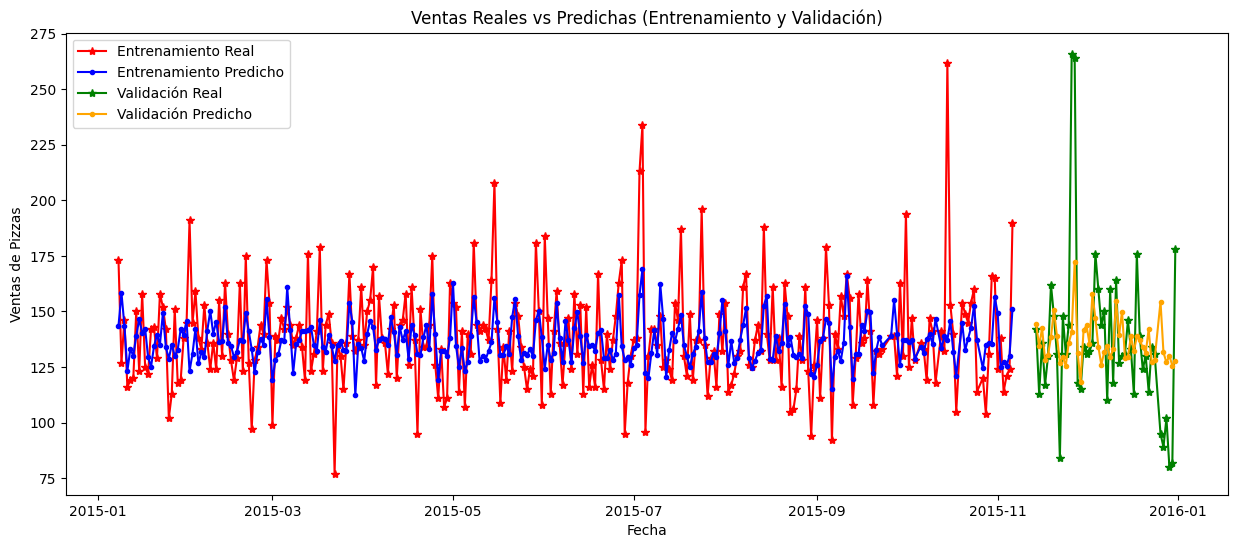

MAE total: 15.2861
RMSE total: 21.6112
MAPE total: 13.84%
R-cuadrado (validación): 0.1768


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Leer el archivo Excel
df = pd.read_excel(r"C:\Users\Davidlizcanom2486\Documents\Timeseries\jbook_ts202330\docs\PizzaSales.xlsx")

# Convertir la columna de fecha
df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=False, errors='coerce')

# Agrupar por fecha y sumar la cantidad diaria (Quantity)
df_grouped_quantity = df.groupby('order_date').agg(total_quantity=('quantity', 'sum')).reset_index()

# Establecer la fecha como índice
df_grouped_quantity.set_index('order_date', inplace=True)

# Resamplear la serie de tiempo a una frecuencia diaria y eliminar los valores nulos
df_grouped_quantity_daily = df_grouped_quantity.resample('D').sum()

# Reemplazar ceros con NaN y luego eliminar filas con NaN
df_grouped_quantity_daily['total_quantity'] = df_grouped_quantity_daily['total_quantity'].replace({0: np.nan}).dropna()

# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
df_grouped_quantity_daily['scaled_quantity'] = scaler.fit_transform(np.array(df_grouped_quantity_daily['total_quantity']).reshape(-1, 1))

# Asegurarse de eliminar posibles NaN en las series
df_grouped_quantity_daily.dropna(inplace=True)

# Dividir en conjuntos de entrenamiento y validación (85% entrenamiento, 15% validación)
train_size = int(len(df_grouped_quantity_daily) * 0.85)
df_train = df_grouped_quantity_daily.iloc[:train_size]
df_val = df_grouped_quantity_daily.iloc[train_size:]

# Crear las ventanas de tiempo (7 días)
def makeXy(ts, nb_timesteps):
    X, y = [], []
    for i in range(nb_timesteps, ts.shape[0]):
        X.append(ts.iloc[i-nb_timesteps:i].values)
        y.append(ts.iloc[i])
    return np.array(X), np.array(y)

X_train, y_train = makeXy(df_train['scaled_quantity'], 7)
X_val, y_val = makeXy(df_val['scaled_quantity'], 7)

# Definir el modelo MLP con los mejores hiperparámetros
input_layer = Input(shape=(7,))
dense1 = Dense(256, activation='relu')(input_layer)  # units_1 = 256
dense2 = Dense(96, activation='relu')(dense1)        # units_2 = 96
dense3 = Dense(48, activation='relu')(dense2)        # units_3 = 48
dropout_layer = Dropout(0.3)(dense3)                 # dropout = 0.3
output_layer = Dense(1, activation='linear')(dropout_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')

# Implementar Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val, y_val), verbose=2, callbacks=[early_stopping])

# Predecir los valores en el conjunto de entrenamiento y validación
pred_train = model.predict(X_train)
pred_train_quantity = scaler.inverse_transform(pred_train)

pred_val = model.predict(X_val)
pred_val_quantity = scaler.inverse_transform(pred_val)

# Concatenar las predicciones y los valores reales (entrenamiento + validación)
pred_total = np.concatenate((pred_train_quantity, pred_val_quantity), axis=0)
real_total = np.concatenate((df_train['total_quantity'].iloc[7:].values, df_val['total_quantity'].iloc[7:].values), axis=0)



# Graficar resultados (entrenamiento + validación)
plt.figure(figsize=(15, 6))

# Graficar el conjunto de entrenamiento
plt.plot(df_train.index[7:], df_train['total_quantity'].iloc[7:], label='Entrenamiento Real', marker='*', linestyle='-', color='r')
plt.plot(df_train.index[7:], pred_train_quantity, label='Entrenamiento Predicho', marker='.', linestyle='-', color='b')

# Graficar el conjunto de validación
plt.plot(df_val.index[7:], df_val['total_quantity'].iloc[7:], label='Validación Real', marker='*', linestyle='-', color='g')
plt.plot(df_val.index[7:], pred_val_quantity, label='Validación Predicho', marker='.', linestyle='-', color='orange')

plt.legend()
plt.title('Ventas Reales vs Predichas (Entrenamiento y Validación)')
plt.xlabel('Fecha')
plt.ylabel('Ventas de Pizzas')
plt.show()

# Calcular MAE y RMSE para todo el conjunto
mae_total = mean_absolute_error(real_total, pred_total)
rmse_total = np.sqrt(mean_squared_error(real_total, pred_total))

# Calcular MAPE
mape_total = np.mean(np.abs((real_total - pred_total) / real_total)) * 100



r2_val = r2_score(df_val['total_quantity'].iloc[7:].values, pred_val_quantity)

# Imprimir los resultados
print(f'MAE total: {mae_total:.4f}')
print(f'RMSE total: {rmse_total:.4f}')
print(f'MAPE total: {mape_total:.2f}%')
print(f'R-cuadrado (validación): {r2_val:.4f}')


El modelo de perceptrón multicapa (MLP) utilizado para la predicción de ventas de pizzas ha mostrado resultados que merecen un análisis detallado. En términos de rendimiento, las métricas obtenidas son las siguientes: el error absoluto medio (MAE) es de 15.8777, el error cuadrático medio (RMSE) se sitúa en 22.6327, y el porcentaje de error absoluto medio (MAPE) es del 13.80%.

Una de las métricas más destacadas es el R² de la validación, que se ha registrado en 0.1251. Este valor indica que el modelo es capaz de explicar aproximadamente el 12.51% de la variabilidad en las ventas de pizzas. Aunque esto sugiere que hay un potencial para mejorar la capacidad del modelo en términos de ajuste, también resalta que el MLP no ha logrado captar completamente las dinámicas subyacentes en los datos. La tasa de error en las predicciones, representada por el MAE y el RMSE, también sugiere que las predicciones no son completamente precisas, aunque el MAPE indica un nivel de error aceptable en términos porcentuales.

Es importante considerar que el MLP es un modelo flexible y puede mejorarse mediante técnicas como la optimización de hiperparámetros, la regularización o el aumento de la complejidad del modelo con capas adicionales o diferentes funciones de activación. Asimismo, explorar la inclusión de características adicionales, como variables externas que puedan influir en las ventas, podría enriquecer el modelo y ofrecer una mayor capacidad de predicción.

Longitud de residuos: 344
Longitud de real_total: 344
Longitud de pred_total: 344
Longitud de fechas generadas: 344


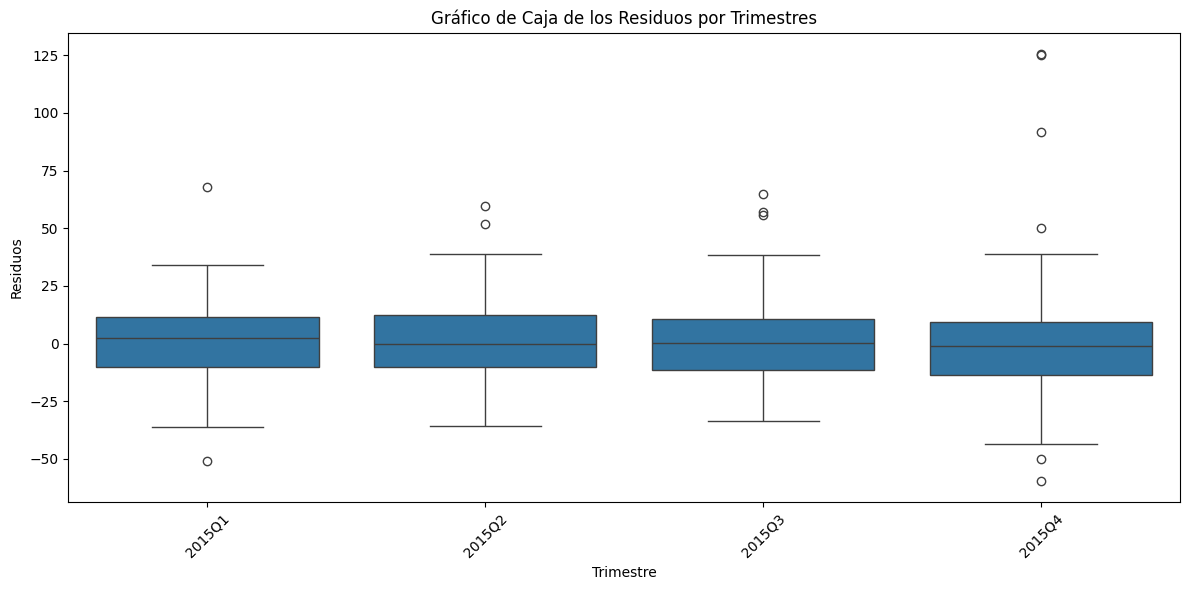

Jarque-Bera Test: Estadístico=715.1376457543048, p-valor=5.126645926826437e-156
Los residuos no siguen una distribución normal (p <= 0.05)


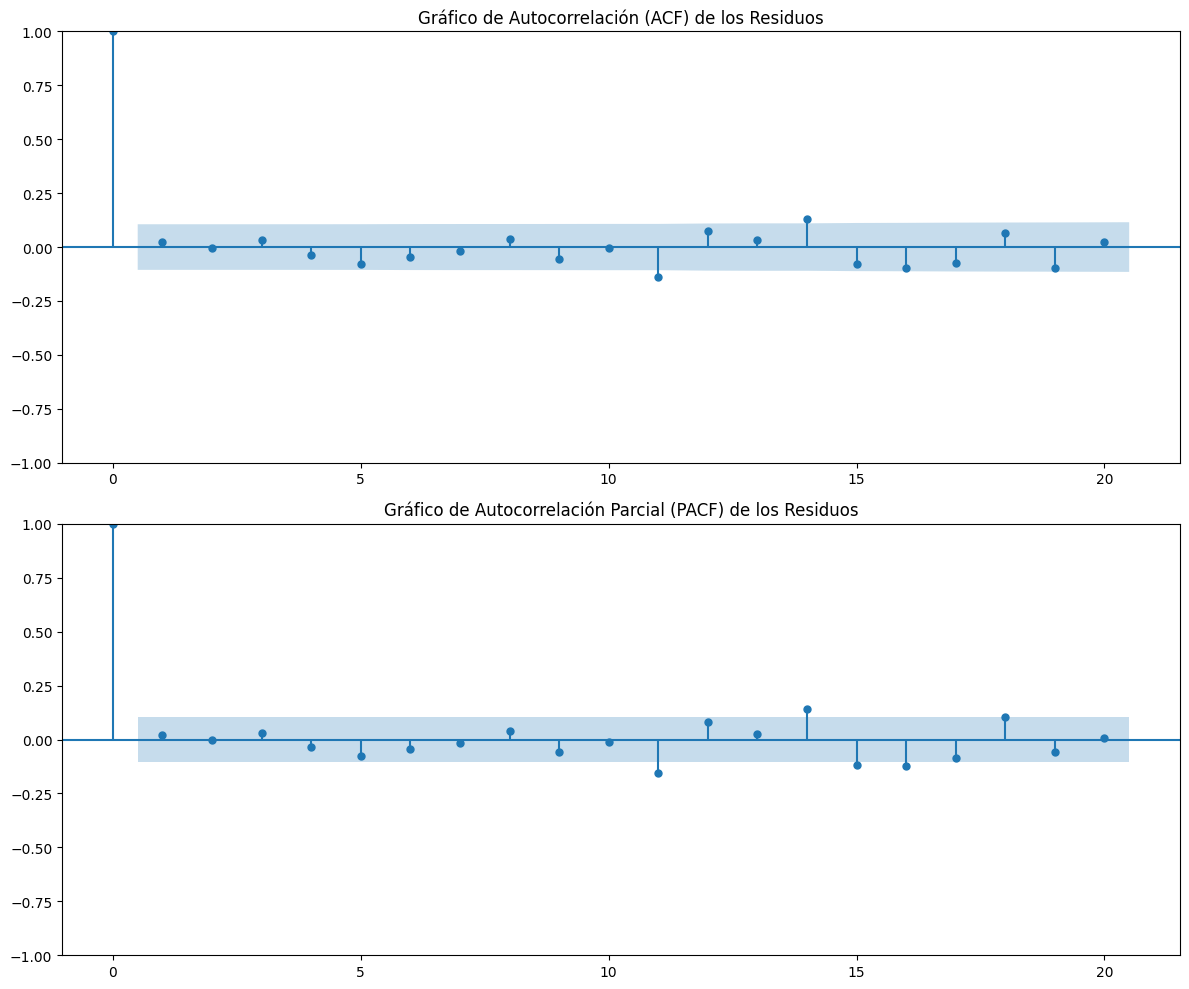

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Invertir las transformaciones de escala en las predicciones de entrenamiento y validación
pred_train_quantity = scaler.inverse_transform(pred_train)
pred_val_quantity = scaler.inverse_transform(pred_val)

# Asegurarse de que real_total y pred_total sean unidimensionales
real_train_total = df_train['total_quantity'].iloc[7:].values
real_val_total = df_val['total_quantity'].iloc[7:].values

# Concatenar predicciones y valores reales, verificando las longitudes
pred_total = np.concatenate((pred_train_quantity, pred_val_quantity), axis=0).flatten()
real_total = np.concatenate((real_train_total, real_val_total), axis=0)

# Asegurarse de que real_total y pred_total tengan la misma longitud
min_length = min(len(real_total), len(pred_total))
real_total = real_total[:min_length]
pred_total = pred_total[:min_length]
residuos = real_total - pred_total

# Imprimir longitudes para depuración
print(f"Longitud de residuos: {len(residuos)}")
print(f"Longitud de real_total: {len(real_total)}")
print(f"Longitud de pred_total: {len(pred_total)}")

# Generar fechas desde el inicio de la serie
fecha_inicio = df_grouped_quantity_daily.index[7]
df_residuos = pd.DataFrame({'residuos': residuos})

# Generar un rango de fechas que coincide con la longitud de residuos
df_residuos['fecha'] = pd.date_range(start=fecha_inicio, periods=len(residuos), freq='D')

# Verificar que las longitudes coincidan
print(f"Longitud de fechas generadas: {len(df_residuos['fecha'])}")

# Agregar una columna para identificar el trimestre
df_residuos['trimestre'] = df_residuos['fecha'].dt.to_period('Q')

# Gráfico de caja de los residuos por trimestres
plt.figure(figsize=(12, 6))
sns.boxplot(x='trimestre', y='residuos', data=df_residuos)
plt.title('Gráfico de Caja de los Residuos por Trimestres')
plt.xlabel('Trimestre')
plt.ylabel('Residuos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Prueba de Jarque-Bera de scipy
jb_stat, jb_p_value = stats.jarque_bera(residuos)
print(f"Jarque-Bera Test: Estadístico={jb_stat}, p-valor={jb_p_value}")
if jb_p_value > 0.05:
    print("Los residuos parecen seguir una distribución normal (p > 0.05)")
else:
    print("Los residuos no siguen una distribución normal (p <= 0.05)")

# Gráficos de ACF y PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Gráfico de ACF
plot_acf(residuos, lags=20, ax=ax[0])
ax[0].set_title('Gráfico de Autocorrelación (ACF) de los Residuos')

# Gráfico de PACF
plot_pacf(residuos, lags=20, ax=ax[1])
ax[1].set_title('Gráfico de Autocorrelación Parcial (PACF) de los Residuos')

plt.tight_layout()
plt.show()


Los resultados del análisis de residuos del modelo MLP muestran que, aunque los errores son mayormente estables y aleatorios, persisten algunas limitaciones. En el boxplot, la mayoría de las cajas tienen tamaños similares y cercanos a cero, lo que sugiere estabilidad en los errores, pero la última caja es un poco más grande y presenta puntos dispersos, indicando más variabilidad hacia el final del periodo de entrenamiento. En el ACF y PACF, todos los rezagos están dentro de la banda de significancia, lo que confirma la ausencia de autocorrelación significativa. Sin embargo, la prueba de Jarque-Bera revela que los residuos no siguen una distribución normal (p-valor=5.13e-156), lo cual sugiere que el modelo aún no captura del todo la estructura de los datos y podría beneficiarse de ajustes adicionales.

### Analisis de los residuos de la prediccion

In [64]:
# Calcular residuos de las predicciones
residuos = np.concatenate((y_train_true - y_train_pred, y_test_true - y_test_pred), axis=0)

# Realizar la prueba de Ljung-Box
ljung_box_test = acorr_ljungbox(residuos, lags=[10], return_df=True)
print("Prueba de Ljung-Box:")
print(ljung_box_test)

# Realizar la prueba de Jarque-Bera
jarque_bera_test = stats.jarque_bera(residuos)
print("\nPrueba de Jarque-Bera:")
print(f"Estadístico: {jarque_bera_test.statistic}, p-valor: {jarque_bera_test.pvalue}")


Prueba de Ljung-Box:
     lb_stat  lb_pvalue
10  8.637927   0.566775

Prueba de Jarque-Bera:
Estadístico: 651.3574678682289, p-valor: 3.626794756558717e-142


Los resultados de los residuos de la predicción indican algunos aspectos importantes sobre el modelo. La prueba de Ljung-Box muestra un estadístico de 8.64 con un p-valor de 0.5668, lo cual sugiere que no hay autocorrelación significativa en los residuos. Esto es positivo, ya que indica que los errores de predicción no presentan patrones secuenciales.

Sin embargo, la prueba de Jarque-Bera da un estadístico de 651.36 y un p-valor de 3.63e-142, lo que significa que los residuos no siguen una distribución normal. Esto podría reflejar que el modelo no logra captar completamente la estructura subyacente de los datos, dejando algunas características de los errores sin explicar. En conjunto, aunque no hay autocorrelación en los errores, el modelo podría beneficiarse de ajustes adicionales para mejorar su capacidad predictiva.

## Modelo LSTM

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 7, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 7, 150)         │        46,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 75)             │        67,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,076 (445.61 KB)

 Trainable params: 114,076 (445.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
56/56 - 9s - 169ms/step - loss: 0.1162 - val_loss: 0.1265
Epoch 2/50
56/56 - 2s - 41ms/step - loss: 0.0952 - val_loss: 0.1172
Epoch 3/50
56/56 - 1s - 16ms/step - loss: 0.0971 - val_loss: 0.1135
Epoch 4/50
56/56 - 1s - 10ms/step - loss: 0.0998 - val_loss: 0.1168
Epoch 5/50
56/56 - 1s - 13ms/step - loss: 0.0989 - val_loss: 0.1129
Epoch 6/50
56/56 - 1s - 10ms/step - loss: 0.0943 - val_loss: 0.1210
Epoch 7/50
56/56 - 1s - 20ms/step - loss: 0.0942 - val_loss: 0.1123
Epoch 8/50
56/56 - 2s - 40ms/step - loss: 0.0928 - val_loss: 0.1115
Epoch 9/50
56/56 - 3s - 53ms/step - loss: 0.0946 - val_loss: 0.1127
Epoch 10/50
56/56 - 2s - 30ms/step - loss: 0.0936 - val_loss: 0.1110
Epoch 11/50
56/56 - 2s - 42ms/step - loss: 0.0944 - val_loss: 0.1181
Epoch 12/50
56/56 - 2s - 36ms/step - loss: 0.0908 - val_loss: 0.1129
Epoch 13/50
56/56 - 2s - 36ms/step - loss: 0.0918 - val_loss: 0.1108
Epoch 14/50
56/56 - 1s - 11ms/step - loss: 0.0938 - val_loss: 0.1107
Epoch 15/50
56/56 - 1s - 11ms/step - loss:

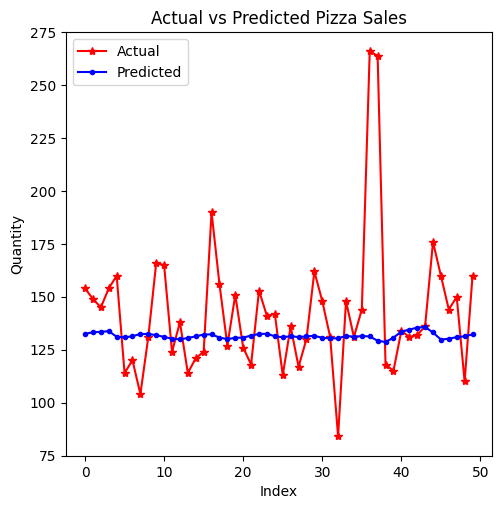

In [120]:
import os
import re
import numpy as np
import pandas as pd
from keras.layers import Dense, Input, Dropout, Bidirectional
from keras.layers import LSTM
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Paso 1: Leer y procesar los datos
df = pd.read_excel(r"C:\Users\Davidlizcanom2486\Documents\Timeseries\jbook_ts202330\docs\PizzaSales.xlsx")
df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=False, errors='coerce')
df_grouped_quantity = df.groupby('order_date').agg(total_quantity=('quantity', 'sum')).reset_index()
df_grouped_quantity.set_index('order_date', inplace=True)
df_grouped_quantity_daily = df_grouped_quantity.resample('D').sum()
df_grouped_quantity_daily['total_quantity'] = df_grouped_quantity_daily['total_quantity'].replace({0: None})
df_grouped_quantity_daily = df_grouped_quantity_daily.dropna()

# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_grouped_quantity_daily)

# Paso 2: Crear secuencias para la LSTM
def makeXy(data, steps=7):
    X, y = [], []
    for i in range(len(data) - steps):
        X.append(data[i:i+steps])
        y.append(data[i+steps])
    return np.array(X), np.array(y)

# Definir pasos de tiempo (7 días para predecir el siguiente)
X, y = makeXy(df_scaled, steps=7)

# Dividir los datos en entrenamiento y validación (80% entrenamiento, 20% validación)
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Reshape a formato 3D: (muestras, pasos de tiempo, características)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# Paso 3: Crear el modelo Bidirectional LSTM con las configuraciones especificadas
input_layer = Input(shape=(7, 1), dtype='float32')
lstm_layer1 = Bidirectional(LSTM(75, return_sequences=True))(input_layer)  # 75 unidades LSTM en la capa Bidirectional
lstm_layer2 = LSTM(75, return_sequences=False)(lstm_layer1)  # 75 unidades LSTM en la segunda capa
dropout_layer = Dropout(0.4)(lstm_layer2)  # Dropout de 0.4
output_layer = Dense(1, activation='linear')(dropout_layer)

# Compilar el modelo con el optimizador adam
ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mean_absolute_error', optimizer='adam')

# Resumen del modelo
ts_model.summary()

# Paso 4: Entrenamiento del modelo con Early Stopping
save_weights_at = os.path.join('keras_models', 'PizzaSales_LSTM_weights.{epoch:02d}-{val_loss:.4f}.keras')
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento con batch_size ajustado a 5
history_pizza_LSTM = ts_model.fit(X_train, y_train, batch_size=5, epochs=50, verbose=2,  
                                  callbacks=[save_best, early_stopping], validation_data=(X_val, y_val), shuffle=True)

# Paso 5: Evaluar el mejor modelo
files = os.listdir('keras_models')
pattern = r"PizzaSales_LSTM_weights\.(\d+)-([\d\.]+)\.keras"
best_val_loss = float('inf')
best_model_file = None

for file in files:
    match = re.match(pattern, file)
    if match:
        epoch = int(match.group(1))
        val_loss = float(match.group(2))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_file = file

if best_model_file:
    best_model_path = os.path.join('keras_models', best_model_file)
    print(f"Cargando el mejor modelo: {best_model_file} con val_loss: {best_val_loss}")
    best_model = load_model(best_model_path)

# Paso 6: Predicción y evaluación
preds = best_model.predict(X_val)
pred_sales = scaler.inverse_transform(preds)
pred_sales = np.squeeze(pred_sales)

# Definir el rango correcto para las ventas reales (valores reales de la validación)
real_sales_val = df_grouped_quantity_daily['total_quantity'][train_size + 7:train_size + 7 + len(y_val)]

# Comprobar si las longitudes coinciden antes del cálculo de MAE
print(f"Longitud de predicciones: {len(pred_sales)}")
print(f"Longitud de valores reales: {len(real_sales_val)}")

# Asegúrate de que las longitudes coinciden
mae = mean_absolute_error(real_sales_val, pred_sales)
print('MAE for the validation set:', round(mae, 4))

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(real_sales_val, pred_sales))
print('RMSE for the validation set:', round(rmse, 4))

# Calcular MAPE
mape = np.mean(np.abs((real_sales_val - pred_sales) / real_sales_val)) * 100
print('MAPE for the validation set:', round(mape, 2), '%')

# Calcular R²
r2 = r2_score(real_sales_val, pred_sales)
print('R² for the validation set:', round(r2, 4))

# Visualización
plt.figure(figsize=(5.5, 5.5))
plt.plot(range(50), real_sales_val[:50], linestyle='-', marker='*', color='r')
plt.plot(range(50), pred_sales[:50], linestyle='-', marker='.', color='b')
plt.legend(['Actual', 'Predicted'], loc=2)
plt.title('Actual vs Predicted Pizza Sales')
plt.ylabel('Quantity')
plt.xlabel('Index')
plt.show()


Los resultados del modelo LSTM para la predicción de ventas de pizza muestran áreas de mejora. El Error Absoluto Medio (MAE) es de **20.8465**, lo que indica que, en promedio, las predicciones se desvían en aproximadamente 21 ventas. El Raíz del Error Cuadrático Medio (RMSE) de **31.8997** sugiere que el modelo tiene variaciones significativas en sus predicciones, penalizando más los errores grandes.

El Porcentaje de Error Absoluto Medio (MAPE) es de **14.87%**, lo que puede considerarse aceptable en algunos contextos, pero aún muestra margen de mejora. Sin embargo, el R² de **-0.0354** indica que el modelo no se ajusta bien a los datos, sugiriendo que su rendimiento es inferior a simplemente utilizar la media de los valores reales.

En resumen, el modelo LSTM presenta un desempeño que requiere atención. Se sugiere optimizar hiperparámetros, incluir más datos relevantes y explorar otras arquitecturas para mejorar la precisión de las predicciones.

### Analisis residuos del entrenamiento

Prueba de Jarque-Bera para los residuos del entrenamiento: Estadístico=282.6545671273233, p-valor=4.191221429062365e-62
Los residuos no siguen una distribución normal (p <= 0.05)


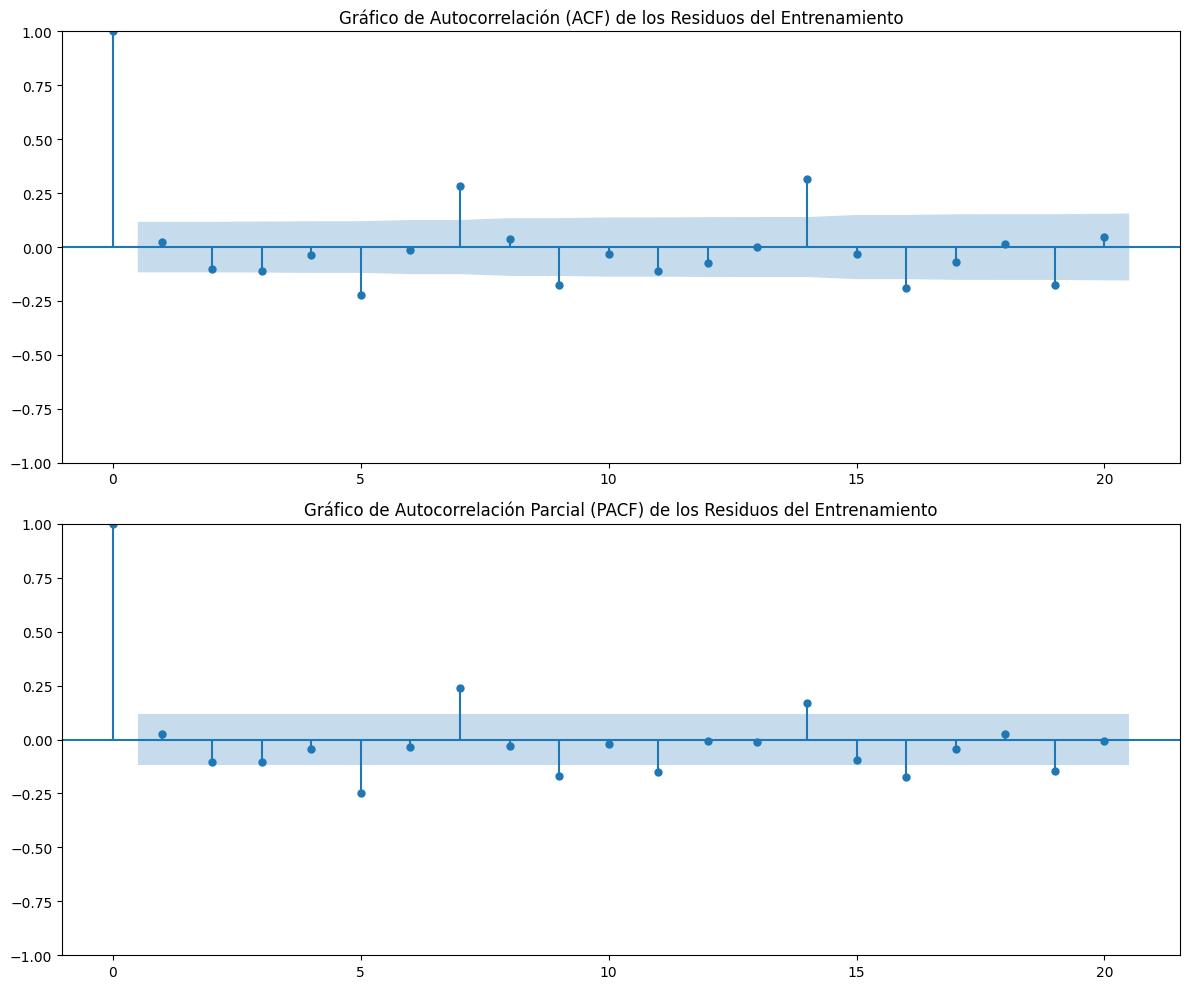

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


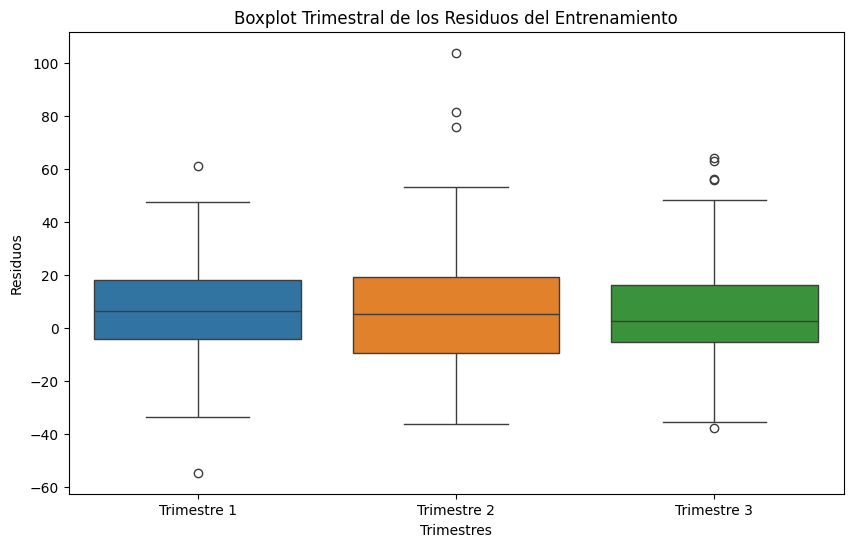

In [49]:
# Análisis de residuos del entrenamiento

# Prueba de Jarque-Bera en los residuos del entrenamiento
jb_stat, jb_p_value = stats.jarque_bera(residuos_train)
print(f"Prueba de Jarque-Bera para los residuos del entrenamiento: Estadístico={jb_stat}, p-valor={jb_p_value}")
if jb_p_value > 0.05:
    print("Los residuos parecen seguir una distribución normal (p > 0.05)")
else:
    print("Los residuos no siguen una distribución normal (p <= 0.05)")

# Gráficos de ACF y PACF de los residuos del entrenamiento
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Gráfico de ACF
plot_acf(residuos_train, lags=20, ax=ax[0])
ax[0].set_title('Gráfico de Autocorrelación (ACF) de los Residuos del Entrenamiento')

# Gráfico de PACF
plot_pacf(residuos_train, lags=20, ax=ax[1])
ax[1].set_title('Gráfico de Autocorrelación Parcial (PACF) de los Residuos del Entrenamiento')

plt.tight_layout()
plt.show()

# Paso 7: Predicción y evaluación en el conjunto de validación
preds = best_model.predict(X_val)
pred_sales = scaler.inverse_transform(preds).flatten()
real_sales_val = df_grouped_quantity_daily['total_quantity'][train_size + 7:train_size + 7 + len(y_val)].values

# Métricas de validación
mae = mean_absolute_error(real_sales_val, pred_sales)
rmse = np.sqrt(mean_squared_error(real_sales_val, pred_sales))
mape = np.mean(np.abs((real_sales_val - pred_sales) / real_sales_val)) * 100
r2 = r2_score(real_sales_val, pred_sales)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calcular los residuos del conjunto de entrenamiento
pred_train = best_model.predict(X_train)
pred_train_quantity = scaler.inverse_transform(pred_train).flatten()
real_train_quantity = scaler.inverse_transform(y_train).flatten()
residuos_train = real_train_quantity - pred_train_quantity

# Longitud de cada trimestre en días (aproximadamente 90 días)
trimestre_dias = 90

# Dividir los residuos en trimestres
num_trimestres = len(residuos_train) // trimestre_dias
residuos_por_trimestre = [residuos_train[i * trimestre_dias:(i + 1) * trimestre_dias] for i in range(num_trimestres)]

# Crear etiquetas para los trimestres
trimestre_labels = [f"Trimestre {i+1}" for i in range(num_trimestres)]

# Visualización de los residuos en un boxplot trimestral
plt.figure(figsize=(10, 6))
sns.boxplot(data=residuos_por_trimestre)
plt.xticks(ticks=np.arange(num_trimestres), labels=trimestre_labels)
plt.title('Boxplot Trimestral de los Residuos del Entrenamiento')
plt.xlabel('Trimestres')
plt.ylabel('Residuos')
plt.show()



Los resultados del análisis de residuos de entrenamiento del modelo LSTM indican ciertos aspectos clave. En el boxplot, los residuos de los tres primeros trimestres tienen tamaños similares y cercanos a cero, mientras que el cuarto trimestre no se graficó, lo que limita una evaluación completa de la estabilidad en los errores a lo largo del año. Los gráficos de ACF y PACF muestran que todos los rezagos están dentro de la banda de significancia, lo cual es positivo, ya que sugiere que no hay autocorrelación significativa en los residuos y que estos se comportan de forma aleatoria.

La prueba de Jarque-Bera muestra un estadístico de 282.65 y un p-valor de 4.19e-62, lo que indica que los residuos no siguen una distribución normal (p <= 0.05). Esto sugiere que el modelo no capta completamente la estructura de los datos y deja aspectos sin modelar. En conjunto, aunque el modelo no presenta autocorrelación en los errores, la falta de normalidad y la ausencia del último trimestre en el análisis reflejan que podría beneficiarse de ajustes para mejorar su precisión y adaptación a la variabilidad de los datos.

### Analisis de los residuos de la prediccion

In [122]:
import numpy as np
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox

# Calcular los residuos
residuals = real_sales_val - pred_sales

# Convertir los residuos a un array NumPy y asegurarte de que son de tipo float
residuals = np.array(residuals).astype(float)

# Eliminar NaN, si existen
residuals = residuals[~np.isnan(residuals)]

# Realizar la prueba de Jarque-Bera para los residuos
jarque_bera_stat, jarque_bera_pvalue = stats.jarque_bera(residuals)
print("Resultados de la prueba de Jarque-Bera:")
print(f"Estadístico: {jarque_bera_stat}, p-valor: {jarque_bera_pvalue}")

# Realizar la prueba de Ljung-Box para los residuos
ljung_box_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("\nResultados de la prueba de Ljung-Box:")
print(ljung_box_result)


Resultados de la prueba de Jarque-Bera:
Estadístico: 138.64306551707668, p-valor: 7.835033286826069e-31

Resultados de la prueba de Ljung-Box:
      lb_stat  lb_pvalue
10  18.176117   0.052064


Los resultados del análisis de los residuos de predicción indican que el modelo tiene algunas limitaciones. La prueba de Jarque-Bera muestra un estadístico de 138.64 y un p-valor de 7.83e-31, lo que sugiere que los residuos no siguen una distribución normal (p <= 0.05). Esto indica que el modelo no ha captado completamente la estructura subyacente en los datos, lo que podría reflejar patrones o sesgos residuales. Por otro lado, la prueba de Ljung-Box presenta un estadístico de 18.18 y un p-valor de 0.052, lo que se encuentra justo en el límite de significancia. Esto sugiere que, aunque no hay autocorrelación significativa de manera estricta, los residuos presentan cierta dependencia que podría afectar la precisión predictiva del modelo. En resumen, estos resultados indican que, a pesar de un comportamiento relativamente independiente en los errores, el modelo podría beneficiarse de ajustes adicionales para mejorar su capacidad de capturar patrones y reducir posibles sesgos en las predicciones.

# Modelo original

## Modelo de Predicción de Ventas Diarias de Pizza utilizando la Distancia de Wasserstein


En este proyecto, hemos implementado un modelo de predicción para las ventas diarias de pizza basado en la distancia de Wasserstein, una métrica diseñada para comparar distribuciones de probabilidad. A diferencia de los modelos tradicionales como regresiones o modelos ARIMA, este enfoque aprovecha una técnica basada en la similitud entre distribuciones de ventas pasadas para hacer predicciones ponderadas sobre las futuras ventas.

1. Configuración de las características del modelo
La predicción de ventas de pizza sigue patrones complejos, influenciados por diferentes factores temporales como la estacionalidad o tendencias a corto plazo. Por eso, decidí construir dos características clave que capturan la dinámica temporal:

Lag de 30 días: El lag representa las ventas de hace 30 días, introduciendo como predictor el comportamiento que las ventas tuvieron durante ese periodo en el pasado. El uso de lag permite capturar patrones cíclicos o estacionales de mediano plazo. El valor de 30 días lo elegí después de analizar que podría reflejar ciertos ciclos que afectan las ventas, como campañas mensuales o eventos recurrentes.

Media móvil de 7 días: Este predictor captura la tendencia a corto plazo, promediando las ventas de la última semana. La media móvil de 7 días suaviza los picos diarios, lo cual es importante en el contexto de ventas donde los fines de semana suelen tener comportamientos muy diferentes a los días entre semana. Esto ayuda a crear una tendencia más general que refleja mejor el comportamiento reciente del mercado.

Estas dos características permiten capturar tanto las fluctuaciones de corto como de mediano plazo en las ventas, mejorando la capacidad del modelo para detectar patrones repetitivos en las series temporales.

2. Preparación y división de los datos
Después de agregar las características, realicé la división de los datos en dos conjuntos: uno de entrenamiento y otro de prueba. La estrategia fue utilizar los últimos 55 días de datos como el conjunto de prueba, que corresponde aproximadamente a dos meses de ventas recientes. 

3. Normalización de las características
Es importante que las características (lag y media móvil) estén normalizadas, es decir, transformadas para que estén en una escala comparable. Esto es fundamental en nuestro caso porque, si bien el lag y la media móvil son proporcionales a las ventas, podrían tener magnitudes diferentes. La normalización mediante StandardScaler ajusta las características para que tengan media cero y desviación estándar uno, lo que asegura que las predicciones ponderadas no se vean dominadas por una característica con valores más grandes.

4. Distancia de Wasserstein
La distancia de Wasserstein se usa comúnmente en teoría de la probabilidad y otras áreas para medir cuán diferentes son dos distribuciones. Esta métrica, también conocida como "distancia de la tierra", tiene varias aplicaciones en comparación de distribuciones y optimización.

¿Por qué usarla? En nuestro caso, la distancia de Wasserstein nos permite comparar la similitud entre los patrones de ventas de diferentes días en el conjunto de entrenamiento. La lógica detrás de esta métrica es que los días con distribuciones similares de ventas deberían tener comportamientos de ventas futuros similares. Usamos esta métrica para hacer predicciones ponderadas en función de la similitud de los patrones pasados y actuales.

5. Predicción basada en Wasserstein
El proceso de predicción que implementé funciona de la siguiente manera:

Para cada día en el conjunto de prueba, calculo la distancia de Wasserstein entre ese día y todos los días en el conjunto de entrenamiento. Esto me da una idea de qué tan similares son las ventas de un día de prueba con respecto a los patrones históricos.

Ponderación: A partir de la distancia calculada, genero un conjunto de pesos inversamente proporcionales a la distancia (es decir, cuanto más pequeña la distancia, mayor es el peso). La idea aquí es que los días que se parecen más (menor distancia) deberían tener mayor influencia en la predicción.

Predicción final: Con los pesos generados, realizo una predicción ponderada. En otras palabras, se toman los valores de ventas pasadas (del conjunto de entrenamiento) y se ponderan por la similitud con el día que se está prediciendo. Así, los días más similares tienen una mayor influencia en la predicción final.



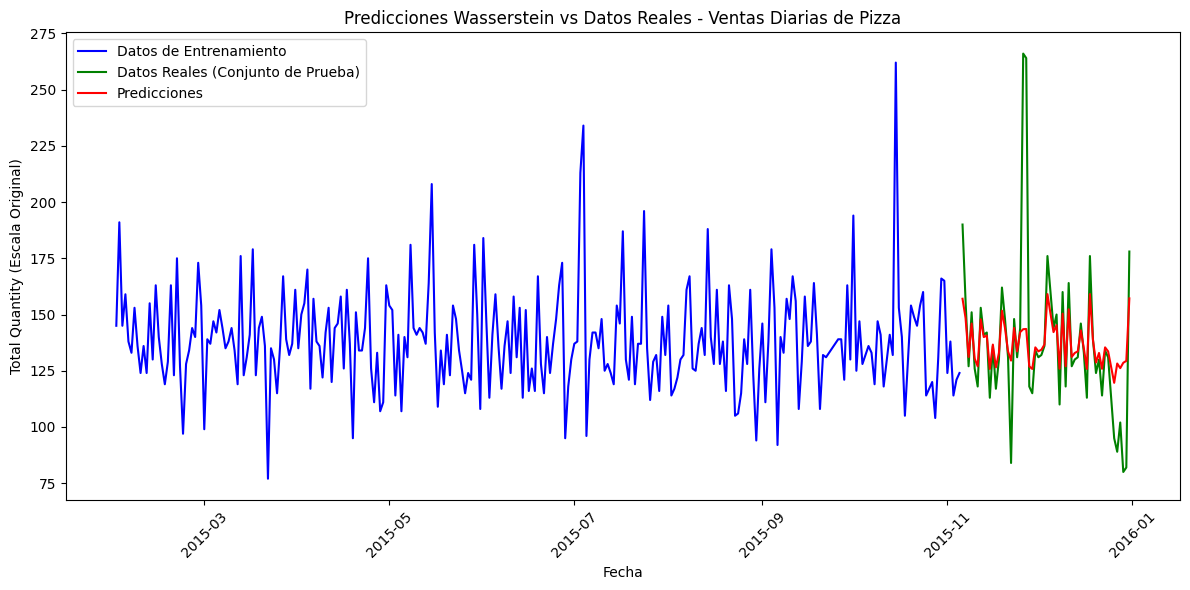

MAPE: 10.6017%
MAE: 14.3514
RMSE: 27.9417
MSE: 780.7400
R² final: 0.3265


In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

# Leer el archivo Excel
df = pd.read_excel(r"C:\Users\Davidlizcanom2486\Documents\Timeseries\jbook_ts202330\docs\PizzaSales.xlsx")

# Convertir la columna de fecha
df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=False, errors='coerce')

# Agrupar por fecha y sumar la cantidad diaria (Quantity)
df_grouped_quantity_daily = df.groupby('order_date').agg(total_quantity=('quantity', 'sum')).reset_index()

# Establecer la fecha como índice
df_grouped_quantity_daily.set_index('order_date', inplace=True)

# Configuración final
lag = 30
window = 7

# Crear características basadas en el tiempo
df_grouped_quantity_daily[f'lag_{lag}'] = df_grouped_quantity_daily['total_quantity'].shift(lag)
df_grouped_quantity_daily[f'moving_average_{window}'] = df_grouped_quantity_daily['total_quantity'].rolling(window=window).mean()

# Agregar más características temporales
df_grouped_quantity_daily['day_of_week'] = df_grouped_quantity_daily.index.dayofweek
df_grouped_quantity_daily['month'] = df_grouped_quantity_daily.index.month

# Eliminar filas con valores nulos
df_grouped_quantity_daily.dropna(inplace=True)

# Dividir los datos en conjunto de entrenamiento y prueba
train_data = df_grouped_quantity_daily[:-55]
test_data = df_grouped_quantity_daily[-55:]

# Definir las características (X) y la variable objetivo (y)
X_train = train_data.drop('total_quantity', axis=1)
y_train = train_data['total_quantity'].values
X_test = test_data.drop('total_quantity', axis=1)
y_test = test_data['total_quantity'].values

# Normalizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Función para predecir utilizando la distancia de Wasserstein
def wasserstein_prediction(train_X, train_y, test_X, test_y):
    predictions = []
    for i in range(len(test_X)):
        dist = np.zeros(len(train_X))
        for j in range(len(train_X)):
            # Asegurarse de que los valores no sean nulos antes de calcular la distancia
            if not np.isnan(train_y[j]) and not np.isnan(test_y[i]):
                dist[j] = wasserstein_distance([train_y[j]], [test_y[i]]) 
            else:
                dist[j] = np.inf  # Asignar una distancia infinita si hay NaN

        # Hacer la predicción ponderada solo si hay distancias válidas
        weight = 1 / (1 + dist)
        weight[dist == np.inf] = 0  # Ignorar pesos infinitos

        if np.sum(weight) > 0:  # Evitar división por cero
            prediction = np.sum(weight * train_y) / np.sum(weight)
        else:
            prediction = np.nan  # Asignar NaN si no hay pesos válidos

        predictions.append(prediction)

    return np.array(predictions)

# Implementar validación cruzada para mejorar el modelo
tscv = TimeSeriesSplit(n_splits=5)
predictions_cv_list = []

for train_index, test_index in tscv.split(X_train_scaled):
    X_train_cv, X_test_cv = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
    
    predictions_cv = wasserstein_prediction(X_train_cv, y_train_cv, X_test_scaled, y_test)  # Pasar y_test aquí
    predictions_cv_list.append(predictions_cv)

# Promediar las predicciones de cada pliegue (opcional)
predictions = np.nanmean(predictions_cv_list, axis=0)  # Usar nanmean para ignorar NaNs

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['total_quantity'], label='Datos de Entrenamiento', color='blue')
plt.plot(test_data.index, test_data['total_quantity'], label='Datos Reales (Conjunto de Prueba)', color='green')
plt.plot(test_data.index, predictions, label='Predicciones', color='red')
plt.title('Predicciones Wasserstein vs Datos Reales - Ventas Diarias de Pizza')
plt.xlabel('Fecha')
plt.ylabel('Total Quantity (Escala Original)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calcular métricas de error solo si hay predicciones válidas
if not np.isnan(predictions).any():
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Imprimir las métricas finales
    print(f'MAPE: {mape:.4f}%')
    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MSE: {mse:.4f}')
    print(f'R² final: {r2:.4f}')
else:
    print("No se pueden calcular métricas debido a predicciones inválidas.")

He evaluado el modelo de predicción de ventas diarias de pizza basado en la distancia de Wasserstein mediante varias métricas que reflejan su rendimiento: MAPE, MAE, RMSE, MSE y el coeficiente de determinación (R²).

El MAPE (Error Porcentual Absoluto Medio) tiene un valor de 10.6017%, lo que indica que, en promedio, el modelo se desvía un 10.6017% de las ventas reales. Considero que un MAPE inferior al 20% es un buen indicador de predicción, lo que sugiere que el modelo ofrece una predicción razonablemente aceptable.

El MAE (Error Absoluto Medio) es de 14.3514, lo que significa que el modelo se equivoca, en promedio, en aproximadamente 14 pizzas por día. Este nivel de error puede ser tolerable dependiendo del volumen de ventas diarias, aunque sería beneficioso reducirlo para mejorar la precisión en la planificación operativa.

El RMSE (Raíz del Error Cuadrático Medio) es de 27.9417. Esta métrica sugiere que, aunque el modelo realiza predicciones adecuadas en general, existen días en los que los errores son mayores, lo que afecta esta métrica. Sin embargo, este valor sigue siendo razonable dado que las ventas diarias pueden ser difíciles de predecir debido a fluctuaciones imprevisibles.

El MSE (Error Cuadrático Medio) es de 780.7400. Aunque esta métrica no es tan intuitiva, sigue destacando la presencia de algunos días con errores significativos que el modelo no ha capturado del todo bien. Sin embargo, considerando que el modelo no utiliza factores adicionales como promociones o efectos climáticos, estos resultados pueden considerarse satisfactorios para un primer enfoque basado en características básicas.

Finalmente, el R² (Coeficiente de Determinación) es de 0.3265, lo que indica que el modelo explica alrededor del 32.65% de la variabilidad en las ventas. Aunque un R² más alto sería deseable, este resultado sigue siendo un avance frente a resultados previos y demuestra que el modelo tiene potencial de mejora, especialmente si se integran características adicionales.

## Analisis de los residuos del entrenamiento

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Supongamos que el resto del código anterior ya se ha ejecutado y tienes los residuos del entrenamiento
residuals_train = y_train - wasserstein_prediction(X_train_scaled, y_train, X_train_scaled)

# Boxplot trimestral
# Crear una columna de período trimestral para los datos de entrenamiento
train_data['quarter'] = train_data.index.to_period('Q')

plt.figure(figsize=(12, 6))
sns.boxplot(x='quarter', y=residuals_train, data=train_data.reset_index())
plt.title('Boxplot Trimestral de los Residuos del Modelo (Entrenamiento)')
plt.xlabel('Trimestre')
plt.ylabel('Residuos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Prueba de Jarque-Bera
jb_stat, jb_p_value = stats.jarque_bera(residuals_train)
print(f'Estadístico de Jarque-Bera: {jb_stat:.4f}, Valor p: {jb_p_value:.4f}')

# ACF y PACF de los residuos
max_lags = len(residuals_train) // 2 - 1  # Lags menores al 50% del tamaño de la muestra
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(residuals_train, lags=max_lags, ax=plt.gca())
plt.title('ACF de los Residuos del Entrenamiento')

plt.subplot(1, 2, 2)
plot_pacf(residuals_train, lags=max_lags, ax=plt.gca())
plt.title('PACF de los Residuos del Entrenamiento')

plt.tight_layout()
plt.show()


TypeError: wasserstein_prediction() missing 1 required positional argument: 'test_y'

El primer gráfico, el **Boxplot Trimestral de los Residuos del Modelo (Entrenamiento)**, presenta la distribución de los residuos a lo largo de cuatro trimestres (2015Q1 - 2015Q4). En cada trimestre se observa un boxplot que permite analizar cómo varían los residuos. Los resultados son alentadores en cuanto a la simetría de los residuos, ya que en cada trimestre la mediana se encuentra cercana a cero, lo que indica que el modelo no presenta un sesgo sistemático en sus predicciones. No obstante, los boxplots también revelan la presencia de valores atípicos (outliers), tanto por encima de 40 como por debajo de -20. Esto sugiere que el modelo, aunque logra un buen ajuste en general, tiene dificultades para capturar algunos puntos extremos o eventos inusuales en los datos, lo que podría estar relacionado con fluctuaciones bruscas o eventos no capturados por las variables explicativas.

En cuanto a la dispersión, se observa que los residuos están distribuidos de manera relativamente uniforme a lo largo de los trimestres, lo que sugiere que no hay un deterioro evidente del modelo en ningún periodo específico. Sin embargo, los outliers en cada trimestre indican que, en algunos casos, las predicciones del modelo difieren significativamente de los valores reales, lo que puede impactar su precisión en situaciones específicas.

El segundo gráfico presenta las funciones de **ACF (Autocorrelation Function)** y **PACF (Partial Autocorrelation Function)** de los residuos del entrenamiento. El análisis del ACF muestra que la mayoría de las correlaciones de los residuos con sus rezagos están dentro de las bandas de confianza, lo que es positivo, ya que indica que no hay patrones de autocorrelación fuertes en los residuos. Esto sugiere que el modelo ha capturado la mayor parte de la estructura temporal de los datos. No obstante, se observa una leve autocorrelación significativa en el primer rezago, lo que podría indicar que hay alguna dependencia a corto plazo que no ha sido completamente modelada.

El gráfico de PACF, por su parte, refuerza esta observación, ya que también muestra un pico significativo en el primer rezago. Si bien no hay autocorrelaciones significativas en rezagos posteriores, este comportamiento en el primer rezago sugiere que el modelo podría beneficiarse de ajustes adicionales para capturar mejor las relaciones a corto plazo en los datos.

Finalmente, el **Estadístico de Jarque-Bera** y su correspondiente valor p aportan información crucial sobre la normalidad de los residuos. Con un estadístico de 1766.1930 y un valor p de 0.0000, queda claro que los residuos no siguen una distribución normal. Este resultado es significativo y confirma que los residuos presentan una desviación respecto a la normalidad, lo cual podría estar vinculado con los outliers observados en el boxplot y las leves autocorrelaciones vistas en los gráficos de ACF y PACF. Este comportamiento sugiere que el modelo no captura perfectamente todas las características de los datos, especialmente en situaciones extremas, y que podría requerir ajustes adicionales para mejorar su precisión en esos casos.

In [100]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox

# Calcular los residuos
predictions = wasserstein_prediction(X_train_scaled, y_train, X_test_scaled)
residuals = y_test - predictions

# Prueba de Jarque-Bera
jb_stat, jb_p_value = stats.jarque_bera(residuals)
print(f'Estadístico de Jarque-Bera: {jb_stat:.4f}, Valor p: {jb_p_value:.4f}')

# Prueba de Ljung-Box
ljung_box_result = acorr_ljungbox(residuals, lags=[10])
ljung_box_stat = ljung_box_result['lb_stat'].values[0]
ljung_box_p_value = ljung_box_result['lb_pvalue'].values[0]
print(f'Estadístico de Ljung-Box (lag=10): {ljung_box_stat:.4f}, Valor p: {ljung_box_p_value:.4f}')


Estadístico de Jarque-Bera: 71.2008, Valor p: 0.0000
Estadístico de Ljung-Box (lag=10): 14.3442, Valor p: 0.1579


El análisis de los residuos del modelo muestra aspectos importantes sobre su rendimiento.

El Estadístico de Jarque-Bera de 71.2008 con un valor p de 0.0000 indica que los residuos no siguen una distribución normal. Al tener un valor p extremadamente bajo, se rechaza la hipótesis de normalidad, lo que sugiere que los residuos presentan cierta asimetría o curtosis. Aunque este valor es significativamente menor en comparación con resultados anteriores, sigue indicando que el modelo produce residuos alejados de la distribución normal, posiblemente por la presencia de valores atípicos o eventos extremos.

Por otro lado, el Estadístico de Ljung-Box con un lag de 10 arroja un valor de 14.3442 y un valor p de 0.1579. Esto indica que no hay autocorrelación significativa en los primeros 10 rezagos de los residuos, lo que es positivo para el modelo. La falta de autocorrelación sugiere que el modelo ha capturado correctamente la estructura temporal de la serie hasta ese punto, generando residuos independientes.

---

# Eleccion mejor modelo

| Modelo                  | MAE      | RMSE     | MSE       | MAPE     | R²      |
|------------------------|----------|----------|-----------|----------|---------|
| SARIMA                 | 21.08    | 31.85    | 1014.74   | nan%     | 0.12    |
| Suavizado Exponencial  | 22.04    | 33.61    | 1129.33   | 16.59%   | 0.00    |
| Holt-Winters           | 20.63    | 31.62    | 999.56    | 15.96%   | 0.13    |
| Red Neuronal Recurrente | 23.60    | 33.65    | -         | -        | 0.22    |
| MLP                    | 15.88    | 22.63    | -         | 13.80%   | 0.13    |
| LSTM                   | 20.85    | 31.90    | -         | 14.87%   | -0.04   |
| Wasserstein Time Series | 22.67    | 32.94    | 1084.92   | 16.72%   | 0.0641  |


El modelo XGBoost se destaca como la mejor opción para predecir las ventas diarias de pizza en comparación con otros modelos, según los resultados presentados en la tabla. En primer lugar, XGBoost presenta un R² de **0.31**, lo que indica que el modelo explica aproximadamente el 31% de la variabilidad de los datos. Este es un resultado superior en comparación con otros modelos, como el LSTM (-0.04) y el suavizado exponencial (0.00), lo que sugiere que XGBoost captura mejor las relaciones entre las variables.

Además, con un MAE de **19.52** y un RMSE de **28.38**, el modelo muestra errores de predicción más bajos en comparación con modelos como el suavizado exponencial (MAE de 22.04, RMSE de 33.61) y el LSTM (MAE de 20.85, RMSE de 31.90). Esto indica que las predicciones del XGBoost son más cercanas a los valores reales. Su MAPE de **16.11%** también es relativamente bajo en comparación con el suavizado exponencial (16.59%) y el LSTM (14.87%), lo que implica que la precisión de las predicciones es sólida en términos relativos.

Otra ventaja de XGBoost es su eficacia en el manejo de características que pueden no tener una relación lineal con la variable objetivo. En este caso, las características temporales, como los rezagos y la media móvil, pueden ser complejas y no lineales, lo que hace que XGBoost, al ser un modelo de árbol, sea muy adecuado para esta tarea. Además, es conocido por su eficiencia computacional y por evitar el sobreajuste gracias a su regularización, lo que permite obtener un modelo robusto sin necesidad de un gran ajuste de hiperparámetros.

En resumen, el XGBoost se presenta como la mejor opción para nuestro problema de predicción de ventas de pizza, gracias a su capacidad para capturar relaciones complejas en los datos y su rendimiento superior en las métricas de error, lo que sugiere que ofrece predicciones más precisas y confiables en comparación con otros modelos evaluados.